# **Processing Data for Model Training**

This tutorial walks you through the methods used to access data from the database and process it in preparation for model training

In [239]:
import pandas as pd
import numpy as np
from scipy.stats import rankdata
#import statsmodels.api as sm
import asyncio
import nest_asyncio
import seaborn as sns
import matplotlib.pyplot as plt
from yeastdnnexplorer.interface import *
nest_asyncio.apply()
from typing import List, Optional
import warnings

In [ ]:
poetry add --group dev statsmodels

## **Accessing combined TF data**

The cell below displays all TFs that contain aggregated data in the database. This is important for using the methods below.

In [240]:
#this code is taken from the database_interface tutorial. For more information on how to use the database, refer to that tutorial.
pss_api = PromoterSetSigAPI()

pss_api.push_params({"datasource": "brent_nf_cc", "aggregated": "true"})

callingcards_aggregated_meta_res = await pss_api.read()

callingcards_aggregated_meta_df = callingcards_aggregated_meta_res.get("metadata")

# Prints the first 3 TFs that have aggregated data available. Modify as necessary to see the whole list of TFs
print(callingcards_aggregated_meta_df["regulator_symbol"][:3])

# Prints the total number of TFs that have aggregated data available.
print("Total number of TFs with aggregated data: "+ str(len(callingcards_aggregated_meta_df["regulator_symbol"])))

0    WTM1
1    MIG2
2    CAT8
Name: regulator_symbol, dtype: object
Total number of TFs with aggregated data: 71


This method asynchronously retrieves and processes data for a given transcription factor. It combines binding and perturbation data, performs necessary calculations, and returns a DataFrame containing both the binding and perturbation data which we will use for further analysis.

In [419]:
#TODO: add a test for this method for future integration into the source code
#NEW: added ability to change perturbation sources
#NEW: added ability to change binding sources
async def process_transcription_factor_async(tf_name: str, is_aggregated: bool, binding_source: str, perturbation_source: str, pseudocount: int = 1) -> pd.DataFrame:    
    """
    Process transcription factor data by retrieving and merging binding and perturbation datasets.

    Params:
        tf_name (str): The name of the transcription factor, i.e. "AR080"
        is_aggregated (bool): Indicates whether the data is aggregated.
        binding_source (str): The source of the binding data, i.e. "cc" or "harbison".
        perturbation_source (str): The source of the perturbation data, i.e. "mcisaac".
        pseudocount (int, optional): The constant used in calculating enrichment and pvalues scores to avoid div by zero, default is 1.

    Returns:
        pd.DataFrame: A DataFrame containing the combined and processed binding and perturbation data.
    """
    # Ensure the TF name is in uppercase to maintain consistency
    tf_name_upper = tf_name.upper()
    
    # Initialize API for binding data
    pss_api_tf = PromoterSetSigAPI()

    # Access the relevant data depending on the binding source and aggregation status
    if binding_source == "cc":
        if is_aggregated:
            pss_api_tf.push_params({'regulator_symbol': tf_name_upper, "datasource": "brent_nf_cc", "aggregated": "true"})
        else:
            pss_api_tf.push_params({'regulator_symbol': tf_name_upper, "workflow": "nf_core_callingcards_1_0_0", "data_usable": "pass"})
    elif binding_source == "harbison":
        pss_api_tf.push_params({'regulator_symbol': tf_name_upper, "source": "4"})

    # Asynchronously read the binding data from the API
    tf_pss = await pss_api_tf.read(retrieve_files=True)
    # Get the ID of the retrieved binding data
    id = tf_pss.get("metadata")["id"][0]
    # Extract the binding data using the ID
    binding_df = tf_pss.get("data").get(str(id))

    # Initialize API for perturbation data
    expression = ExpressionAPI()

    # Map perturbation source to corresponding source number
    source_mapping = {
        "mcisaac": "7",
        "hu_reimann": "5",
        "kemmeren": "6"
    }
    source_number = source_mapping.get(perturbation_source, "unknown")
    
    # Push parameters to retrieve the perturbation data
    if perturbation_source == "mcisaac":
        expression.push_params({"regulator_symbol": tf_name_upper, "source": source_number, "time": "15"})
    else:
        expression.push_params({"regulator_symbol": tf_name_upper, "source": source_number})

    # Asynchronously read the perturbation data from the API
    expression_res = await expression.read(retrieve_files=True)
    # Get the ID of the retrieved perturbation data
    id = expression_res.get("metadata")["id"][0]
    # Extract the perturbation data using the ID
    expression_df = expression_res.get("data").get(str(id))

    # Read perturbation data
    perturbation_data = expression_df
    # Read binding data
    binding_data = binding_df

    # Rename columns in binding data for consistency and clarity
    if binding_source == "cc":
        binding_data.rename(columns={"callingcards_enrichment": "effect", "poisson_pval": "pvalue"}, inplace=True)
    elif binding_source == "harbison":
        binding_data.rename(columns={"pval": "pvalue"}, inplace=True)

    # Optional: here you can modify the pseudocount as needed. The default pseudocount is set to 1.
    # Calculate the effect size for binding data using the provided formula
    if binding_source == "cc":
        binding_data['effect'] = (binding_data['experiment_hops'] / binding_data['experiment_total_hops']) / \
                             ((binding_data['background_hops'] + pseudocount) / binding_data['background_total_hops'])

    # Merge the binding data and perturbation data on the 'target_locus_tag' column
    combined_data = pd.merge(binding_data, perturbation_data, on='target_locus_tag', suffixes=('_binding', '_perturbation'))

    # # Assert that the length of combined_data is the minimum of the lengths of binding_data and perturbation_data
    # assert len(combined_data) <= min(len(binding_data), len(perturbation_data)), \
    #     f"Length of combined_data ({len(combined_data)}) is not equal to the minimum of lengths of binding_data ({len(binding_data)}) and perturbation_data ({len(perturbation_data)})"

    # Keep only the necessary columns in the combined data
    combined_data = combined_data[['target_locus_tag', 'effect_binding', 'effect_perturbation', 'pvalue_binding']]

    # Reorder the combined data by the smallest 'pvalue_binding' values
    combined_data = combined_data.sort_values(by='pvalue_binding')

    # Apply transformations:
    # - Take the absolute value of 'effect_perturbation'
    # - Calculate the negative log10 of 'pvalue_binding'
    # - Calculate the log10 of 'effect_binding'
    combined_data['effect_perturbation'] = combined_data['effect_perturbation'].abs()
    combined_data['neg_log_pvalue_binding'] = -np.log10(combined_data['pvalue_binding'])
    combined_data['log_enrichment'] = np.log10(combined_data['effect_binding'])

    # Return the processed combined data as a DataFrame
    return combined_data


The process_transcription_factor method below is used to call the asynchronous process_transcription_factor_async function above in a way that works with regular, step-by-step code. We need this function to use the method above in loops or other structures that don’t handle asynchronous functions well.

In [321]:
def process_transcription_factor(tf_name: str, is_aggregated: bool, binding_source: str, perturbation_data: str, pseudocount: int = 1) -> pd.DataFrame:
    """
    Processes transcription factor data synchronously by invoking an asynchronous function.

    This function runs the asynchronous process_transcription_factor_async function synchronously to handle 
    transcription factor data processing. It retrieves the event loop, runs the asynchronous function, 
    and returns the processed DataFrame.

    Parameters:
        tf_name (str): The name of the transcription factor.
        is_aggregated (bool): A boolean flag indicating whether the data is aggregated.
        perturbation_source (str): The source of the perturbation data.
        pseudocount (int, optional): The constant used in calculating enrichment and pvalues scores to avoid div by zero, default is 1.

    Returns:
        pd.DataFrame: A DataFrame containing the processed transcription factor data.
    """
    loop = asyncio.get_event_loop()
    return loop.run_until_complete(process_transcription_factor_async(tf_name, is_aggregated, binding_source, perturbation_data, pseudocount))

Here is an example of the method in action: the returned dataframe combines the binding and perturbation data for use below.

In [244]:
process_transcription_factor("AFT1", False, "cc", "hu_reimann")

/Users/ericjia/yeastdnnexplorer/.venv/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/ericjia/yeastdnnexplorer/.venv/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


,target_locus_tag,effect_binding,effect_perturbation,pvalue_binding,neg_log_pvalue_binding,log_enrichment
4773,YEL065W,40.645338,0.307065,0.000000,inf,1.609011
4772,YEL067C,31.354975,0.309224,0.000000,inf,1.496306
1033,YLR136C,90.116521,0.395634,0.000000,inf,1.954804
3828,YCL018W,167.226533,0.055596,0.000000,inf,2.223305
2657,YOR203W,92.903630,0.179912,0.000000,inf,1.968033
...,...,...,...,...,...,...
5685,YGR240C,0.000000,0.070498,0.992207,0.003398,-inf
2542,YOR092W,0.000000,0.041109,0.994933,0.002206,-inf
941,YLR044C,0.000000,0.044537,0.995450,0.001980,-inf
3554,YBR082C,0.130850,0.185228,0.995484,0.001966,-0.883226


## **Applying Transformations to the Data**

The process_dataframe method is used to further process a DataFrame containing combined transcription factor data to facilitate meaningful analysis and visualization. Since various TFs will have different distributions of enrichment scores and poisson pvalues, it is helpful to use a ranking of these values as opposed to the magnitudes themselves to make for easier comparisons. Since there are thousands of data points in each TF, using a log will shrink the scale of these ranks, allowing us to focus better on the trends in the data. We are specifically interested in how the poisson pvalue associated with TF binding relates to the actual perturbation effect. 

Thus, we take the negative log ranks of these two columns to determine if there is a relationship across all TFs. Taking the negative log of the rank means that the highest ranked data will be the least negative. Since we assign higher ranks to smaller poisson pvalues and larger perturbation effects, we would hope to see a positive linear trend when graphing this data as more significant binding interactions should ideally correlate with larger perturbations.

In [427]:
def process_dataframe(df: pd.DataFrame) -> pd.DataFrame:
    """
    Processes a DataFrame further by calculating ranks and log transformations for expression and binding data to elucidate certain trends.

    Params:
        df (pd.DataFrame): The input DataFrame containing 'effect_perturbation' and 'pvalue_binding' columns.

    Returns:
        pd.DataFrame:A DataFrame that includes the original data along with new columns for expression ranks, log-transformed ranks, 
                     binding ranks, and is sorted by the negative log-transformed binding rank.
    """
    # Calculate expression rank with average ties method
    df['expression_rank'] = rankdata(-abs(df['effect_perturbation']), method='average')

    # Log transform the expression rank
    df['neg_expression_rank_log'] = -np.log10(df['expression_rank'])

    # Calculate binding rank with average ties method
    df['binding_rank'] = rankdata(df['pvalue_binding'], method='average')

    # Calculate log transform of the binding rank
    df['neg_log_rank_binding'] = -np.log10(rankdata(df['binding_rank'], method='average'))

    # Select specific columns
    plotting_df = df[['effect_perturbation', 'expression_rank', 'neg_expression_rank_log', 
                      'pvalue_binding', 'binding_rank', 'neg_log_rank_binding']]

    # Arrange (sort) by neg_log_rank_binding in descending order
    plotting_df = plotting_df.sort_values(by='neg_log_rank_binding', ascending=False)
    
    return plotting_df

## **Visualizing the Transformed Data Using Bins**

The create_bins method is designed to create "bins" of data for a specified column in the input DataFrame. Binning data is a method of grouping continuous values into discrete intervals or "bins." This process can help in reducing variance and revealing general trends in a dataset, which is needed in this instance to better see the trend between the rank binding and rank perturbation response across various TFs.

This method gives you the option of adjusting the size of each bin, or selecting the number of bins you want to create. For example, choosing bin_size = None and num_bins = 5 will create 5 bins of equal size that fully contain the entire range of data, but note that the number of data points in each bin may vary. We use this process of binning to make the trends in the data introduced later in the notebook more apparent.

In [428]:
def create_bins(data: pd.DataFrame, column: str, bin_size: Optional[float] = None, num_bins: Optional[int] = None) -> pd.Series:
    """
    Creates bins for a specified column in a DataFrame.

    Params:
        data (pd.DataFrame): A DataFrame containing the data to be binned.
        column (str): The name of the column to be binned.
        bin_size (Optional[float]): The size of each bin (optional, default is None). If specified, the range of the data will be partitioned into bins of this size.
        num_bins (Optional[int]): The number of bins (optional, default is None). If specified, the range of the data will be partitioned into this number of bins.

    Returns:
        pd.Series: A set of bins that partitions the data along the desired column value.
    """
    if bin_size is not None:
        bin_edges = np.arange(data[column].min(), data[column].max() + bin_size, bin_size)
    elif num_bins is not None:
        bin_edges = np.linspace(data[column].min(), data[column].max(), num_bins + 1)
    else:
        raise ValueError("Either bin_size or num_bins must be specified")
    return pd.cut(data[column], bins=bin_edges, include_lowest=True, right=False)

The plot_with_custom_bins method now creates a scatter plot with custom bins and fits a line to connect the points for the binned data. In our case, we use this to provide a visualization of the relationship between the negative log10 rank binding and the negative log10 expression rank, showing the binned means and the general trend.

In [429]:
def plot_with_custom_bins(data: pd.DataFrame, bin_size: Optional[float] = None, num_bins: Optional[int] = None) -> None:
    """
    This function bins the 'neg_log_rank_binding' column using the specified bin size or number of bins, 
    calculates the mean of 'neg_expression_rank_log' for each bin, and plots these means against the 
    bin centers. It also fits a LOESS line on the binned data and displays the number of data points 
    in each bin.

    Params:
        data (pd.DataFrame): The input DataFrame containing 'neg_log_rank_binding' and 'neg_expression_rank_log' columns.
        bin_size (Optional[float]): The size of each bin (optional, default is None). If specified, the range of the data will be partitioned into bins of this size.
        num_bins (Optional[int]): The number of bins (optional, default is None). If specified, the range of the data will be partitioned into this number of bins.

    Returns:
        None
    """
    # Create bins for the 'neg_log_rank_binding' column using the specified bin size or number of bins
    data['bin'] = create_bins(data, 'neg_log_rank_binding', bin_size, num_bins)
    
    # Calculate the mean of 'neg_expression_rank_log' for each bin
    binned_means = data.groupby('bin', observed = True)['neg_expression_rank_log'].mean().reset_index()
    
    # Calculate the center of each bin for the 'neg_log_rank_binding' column
    bin_centers = data.groupby('bin', observed = True)['neg_log_rank_binding'].mean().reset_index()
    
    # Count the number of data points in each bin and sort the counts by bin order
    bin_counts = data['bin'].value_counts().sort_index().reset_index(drop=True)

    # Fit a LOESS line on the binned data. Since there are only a handful of points, this will act as a line that connects the dots.
    #lowess = sm.nonparametric.lowess
    #smoothed_bins = lowess(binned_means['neg_expression_rank_log'], bin_centers['neg_log_rank_binding'], frac=0.3)

    # Plotting the data
    plt.figure(figsize=(10, 6))  # Set the figure size
    # Create a scatter plot of bin centers vs. binned means
    plt.scatter(bin_centers['neg_log_rank_binding'], binned_means['neg_expression_rank_log'], color='blue', label='Binned Means')
    
    # Add the number of data points for each bin as text labels on the plot
    for i in range(len(bin_centers)):
        plt.text(bin_centers['neg_log_rank_binding'][i], binned_means['neg_expression_rank_log'][i] - 0.007, str(bin_counts[i]), 
                 color='black', ha='left', va='top', fontsize=9)
    
    # Plot the LOESS smoothed line
    #plt.plot(smoothed_bins[:, 0], smoothed_bins[:, 1], label='LOESS on Binned Data', color='red', linewidth=2)
    
    # Set the labels and title for the plot
    plt.xlabel('Negative Log10 Rank Binding')  # Label for the x-axis
    plt.ylabel('Negative Log10 Expression Rank')  # Label for the y-axis
    plt.title('Negative Log Rank Binding vs Negative Log Expression Rank on Binned Data')  # Title of the plot
    plt.legend()
    plt.show()

Now that we have covered the main methods, here is an example of them in action. In this case, we are interested in displaying the trend for the single TF "AFT1." We are using a pseudocount of 10.3922 to calculate the enrichment scores and p values. Then we bin the data and graph the scatterplot with the LOESS line.

/Users/ericjia/yeastdnnexplorer/.venv/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/ericjia/yeastdnnexplorer/.venv/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


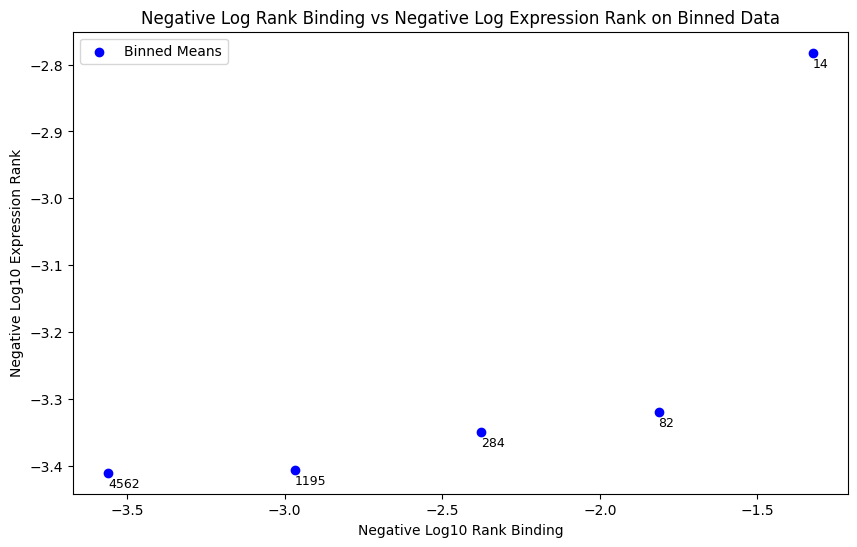

In [248]:
combined_data = process_transcription_factor("AFT1", False, "cc", "mcisaac", 10.3922)
plotting_df = process_dataframe(combined_data)
plot_with_custom_bins(plotting_df, num_bins=5)

The x-axis of this plot is the negative log of the binding poisson pvalue ranks. Recall that ties are handled by taking an average across data points with the same value to assign ranks. Data with smaller pvalue magnitudes are presumed to be more significant, therefore they occupy the highest ranks (i.e. 1, 2, 3, etc.). When taking the negative log of these ranks, points that are closer to 0 constitute points with these higher ranks, and points are that more negative correspond to lower ranked and therefore larger pvalues for binding. 

The y-axis of this plot is the negative log of the perturbation effect ranks. A similar throught-process exists here as it does for the x-axis. However, in this instance, data with larger perturbation effects are more important, and therefore they occupy the higher ranks. Thus, data that is closer to 0 corresponds to higher perturbation effects, and those that are more negative correspond to perturbation effects that are smaller in magnitude.

Also, it is important to notice that the number of datapoints in each of the bins here is not the same. There appear to be significantly more points that occupy the leftmost bin. This means that there are likely many ties among points that have larger binding pvalues, therefore there is a greater concentration of these points in the leftmost bin in contrast to the bins on the right. By the same virtue, there is a significantly smaller quantity of points in the rightmost bin, indicating less ties among points that have smaller binding pvalues.

The general trend of these binned means shows a postive, upward response. This finding aligns with our hypothesis that points with more significant binding effects (which are measured here using the poisson pvalue of binding) should correlate with points that have more significant perturbation effects (measured here using the magnitude of the perturbation effect). However, we hope that the trend is consistent across all TFs, as we seek to identify a general relationship that the model can more easily learn in hopes of enhancing its predictive power.

The process_and_plot_tfs method processes and plots data for a list of transcription factors (TFs). For each TF, it retrieves and processes the data, and then creates a plot using custom bins. This method serves as a comprehensive pipeline to handle multiple TFs, from data retrieval and processing to visualization.

In [325]:
def process_and_plot_tfs(tf_list: List[str], boolean_list: List[bool], binding_source: str, perturbation_source: str, bins: Optional[int] = 5, pseudocount: Optional[int] = 1) -> None:
    """
    Processes and plots data for a list of TFs: This function iterates over each transcription factor in the list, accounting for whether 
    or not they possess aggregate data, processes their data, and generates plots with the specified number of bins for eac.
    
    Params:
        tf_list (List[str]): A list of transcription factor names.
        boolean_list (List[bool]): A list of boolean values indicating whether the data is aggregated for each transcription factor.
        perturbation_source (str): The source of the perturbation data.
        bins (Optional[int]): The number of bins for plotting (optional, default is 5).
        pseudocount (Optional[int]): The constant used in calculating enrichment and pvalues scores to avoid div by zero, default is 1.

    Returns:
        None
    """
    # Suppress RuntimeWarnings for the duration of the following operations
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=RuntimeWarning)
        
        # Iterate over each transcription factor in the list
        for i in range(len(tf_list)):
            print(f"Processing and plotting for TF: {tf_list[i]}")
        
            # Access the transcription factor data
            combined_data = process_transcription_factor(tf_list[i], boolean_list[i], binding_source, perturbation_source, pseudocount)
        
            # Process the combined data to calculate ranks and transformations
            plotting_df = process_dataframe(combined_data)
        
            # Plot the processed data with custom bins
            plot_with_custom_bins(plotting_df, num_bins=bins)

Below is an example of a list of 4 more TFs we want to visualize this trend for, which we can do by utilizing this method

Processing and plotting for TF: MIG2


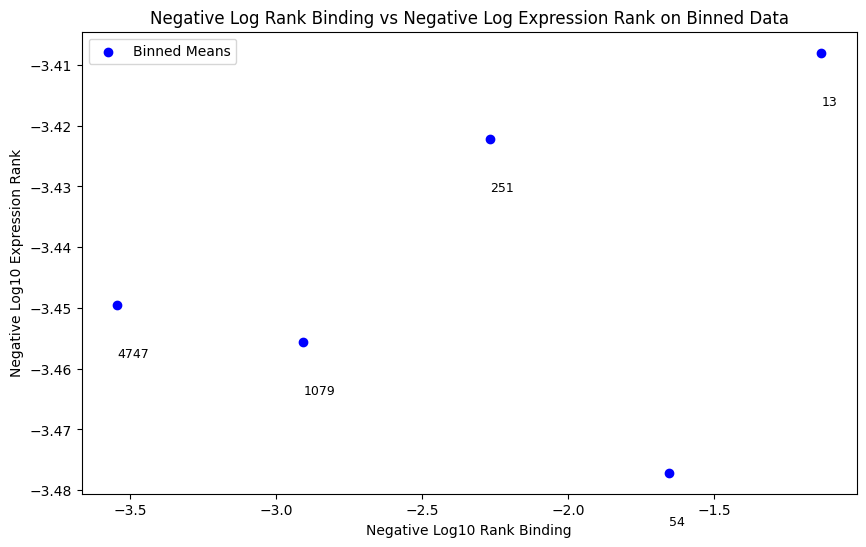

Processing and plotting for TF: CAT8


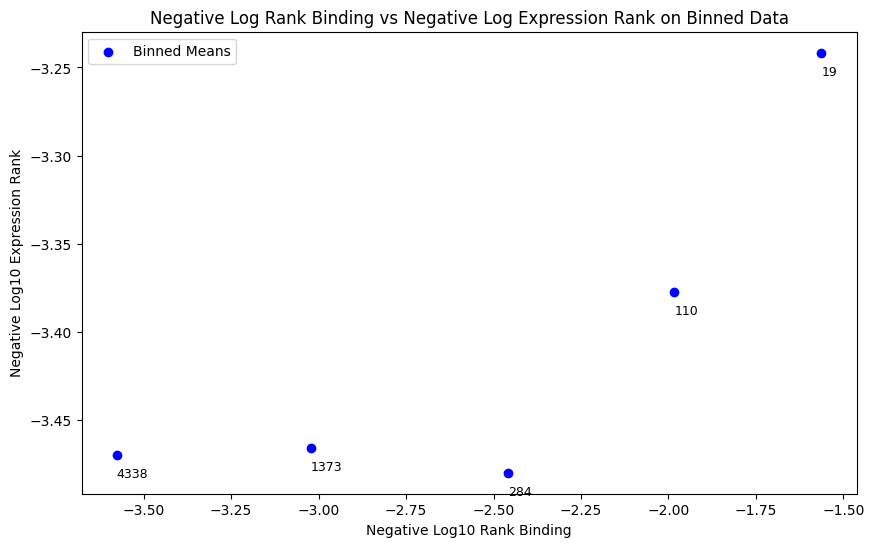

Processing and plotting for TF: PDR1


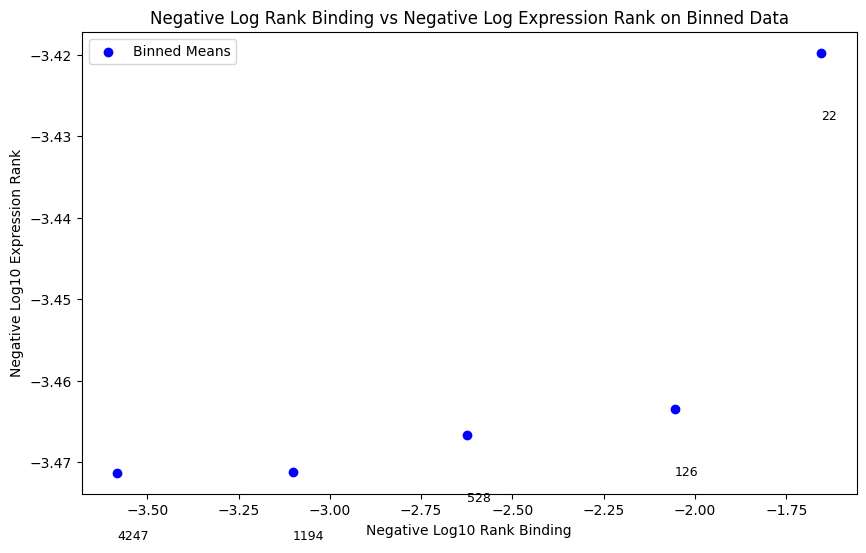

Processing and plotting for TF: PHO4


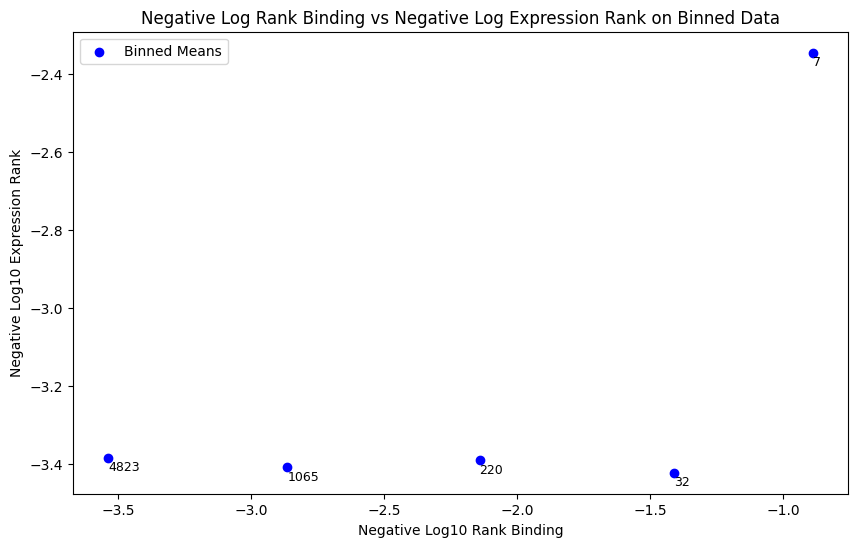

In [252]:
tfs = ['MIG2', 'CAT8', 'PDR1', 'PHO4']
boolean_list = [True] * 4
process_and_plot_tfs(tfs, boolean_list, "cc", "mcisaac")

While the latter 3 plots tend to exhibit the same upward trend as the plot above, the first plot looks more unusual. The second point from the right on this plot representing the binned mean data for that range of negative log rank binding pvalues has a mean negative log expression rank that is significantly lower than expected. This means that for the data points within that bin, which is second only to the bin containing the points with the smallest binding pvalues, has on average the lowest ranked perturbation effects out of all of the bins. We do not know why or how exactly this happens, but it is important to note a model trained on this general trend may not predict the perturbation response as accurately given the different relationship exhibited in this plot.

For the latter 3 plots, there is a noticeably 

For further exploration of this trend across more TFs, below is example of code that will plot the trend for 71 TFs including the 5 shown above. You can continue exploring how this trend persists across TFs.

In [253]:
#tfs = ['WTM1', 'MIG2', 'CAT8', 'PDR1', 'PHO4', 'RIM101', 'GZF3', 'VHR1', 'ASH1', 'GAT3','FHL1', 'TEC1', 'SIP3', 'SKN7', 'WTM2','PHO2', 'HAA1', 'ADR1', 'MET31', 'CRZ1', 'RPH1', 'CHA4', 'CAD1', 'ZAP1', 'SKO1', 'ACA1', 'FZF1', 'HAP2', 'HAP3', 'HAP5','INO4', 'ERT1', 'TOG1', 'MET4', 'PPR1', 'RTG1', 'GLN3', 'MOT3', 'AFT1', 'GIS1', 'CBF1', 'SUM1', 'MSN2', 'DAL80', 'UPC2','RTG3', 'GAL80', 'RSF2', 'RME1', 'HIR2', 'SIP4', 'GCR1', 'HAP4', 'UME1', 'MET32', 'USV1', 'MGA1', 'CIN5', 'ROX1','XBP1', 'ZNF1', 'YHP1', 'RDR1', 'PDR3', 'RLM1', 'SFL1', 'SMP1', 'SUT2', 'HAC1', 'PHD1', 'ARO80']
#len(tfs)
#boolean_list = [True] * 59 + [False] * 12
#process_and_plot_tfs(tfs, boolean_list, "cc", "mcisaac")

## **Further Visualization Techniques on the Binned Data**

As we have seen above, even after transforming the data and applying this method of binning, the general trend that we expect to see if not clearly present in every transcription factor. Due to this, it would be important to investigate how this trend holds up in general across all of the TFs in our database.

For further analysis, the following method adjacent_differences_box_plot will create four boxplots based on the five bins used above. For each TF, it will calculate the difference between two adjacent means, doing this four times total for the five binned means. Then, for each of the four values, the data across all TFs is aggregated, and a boxplot is made for each of these four datasets to visualize the trend in across all TFs.

In [340]:
def adjacent_differences_box_plot(tfs: List[str], boolean_list: List[bool], binding_source: str, perturbation_source: str, bins: int, pseudocount: Optional[int] = 1) -> None:
    """
    Generates a box plot of the differences between adjacent bins for a list of transcription factors.

    This function processes transcription factor data, calculates differences between the means of adjacent bins,
    and generates a box plot to visualize these differences across multiple transcription factors.

    Params:
        tfs (List[str]): A list of transcription factors that you want to plot.
        boolean_list (List[bool]): A list of boolean values indicating whether the data is aggregated for each transcription factor.
        perturbation_source (str): The source of the perturbation data.
        bins (int): The number of bins to create.
        pseudocount (Optional[int]): The constant used in calculating enrichment and pvalues scores to avoid div by zero, default is 1.

    Returns:
        None
    """
    # Initialize a list of lists to store differences between adjacent bins for each TF
    diff_data = [[] for _ in range(bins - 1)]

    # Suppress RuntimeWarnings for the duration of the following operations
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=RuntimeWarning)

        # Iterate over each transcription factor in the list
        for i in range(len(tfs)):            
            # Process the transcription factor data
            combined_data = process_transcription_factor(str(tfs[i]), boolean_list[i], binding_source, perturbation_source, pseudocount)
            
            # Further process the combined data to calculate ranks and transformations
            plotting_df = process_dataframe(combined_data)
            
            # Create bins for the 'neg_log_rank_binding' column using the specified number of bins
            plotting_df['bin'] = create_bins(plotting_df, 'neg_log_rank_binding', num_bins=bins)
            
            # Calculate the mean of 'neg_expression_rank_log' for each bin
            binned_means = plotting_df.groupby('bin', observed=True)['neg_expression_rank_log'].mean().reset_index()
            
            # Initialize a list to store the differences between adjacent bins
            binned_mean_diffs = []
            
            # Calculate the differences between the means of adjacent bins
            for j in range(bins - 1):
                binned_mean_diffs.append(binned_means["neg_expression_rank_log"][j+1] - binned_means["neg_expression_rank_log"][j])
            
            # Append the differences to the corresponding list in diff_data
            for j in range(bins - 1):
                diff_data[j].append(binned_mean_diffs[j])


    # Remove NaN values from all bin difference lists
    diff_data = [[x for x in bin_diff if not pd.isnull(x)] for bin_diff in diff_data]

    # Create a boxplot
    plt.figure(figsize=(12, 8))
    plt.boxplot(diff_data)
    plt.axhline(y=0, color='gray', linestyle='--')  # Add a horizontal dotted line at y=0
    plt.xlabel('Adjacent Bin Differences')  
    plt.ylabel('Negative Log10 Expression Rank')  
    plt.title(f'Boxplots of Aggregate Data Across {len(tfs)} TFs')
    
    # Set x-tick labels dynamically based on the number of bins
    plt.xticks(ticks=range(1, bins), labels=[f'Bins {i+1} and {i+2}' for i in range(bins - 1)])    
    plt.show()

Here, we use this method to plot the boxplots for the above TF data.

In [327]:
tfs = ['WTM1', 'MIG2', 'CAT8', 'PDR1', 'PHO4', 'RIM101', 'GZF3', 'VHR1', 'ASH1', 'GAT3','FHL1', 'TEC1', 'SIP3', 'SKN7', 'WTM2','PHO2', 'HAA1', 'ADR1', 'MET31', 'CRZ1', 'RPH1', 'CHA4', 'CAD1', 'ZAP1', 'SKO1', 'ACA1', 'FZF1', 'HAP2', 'HAP3', 'HAP5','INO4', 'ERT1', 'TOG1', 'MET4', 'PPR1', 'RTG1', 'GLN3', 'MOT3', 'AFT1', 'GIS1', 'CBF1', 'SUM1', 'MSN2', 'DAL80', 'UPC2','RTG3', 'GAL80', 'RSF2', 'RME1', 'HIR2', 'SIP4', 'GCR1', 'HAP4', 'UME1', 'MET32', 'USV1', 'MGA1', 'CIN5', 'ROX1','XBP1', 'ZNF1', 'YHP1', 'RDR1', 'PDR3', 'RLM1', 'SFL1', 'SMP1', 'SUT2', 'HAC1', 'PHD1', 'ARO80']
#Assigning the correct boolean to each TF based on whether the TF contains aggregated data in the database or not
boolean_list = [True] * 59 + [False] * 12

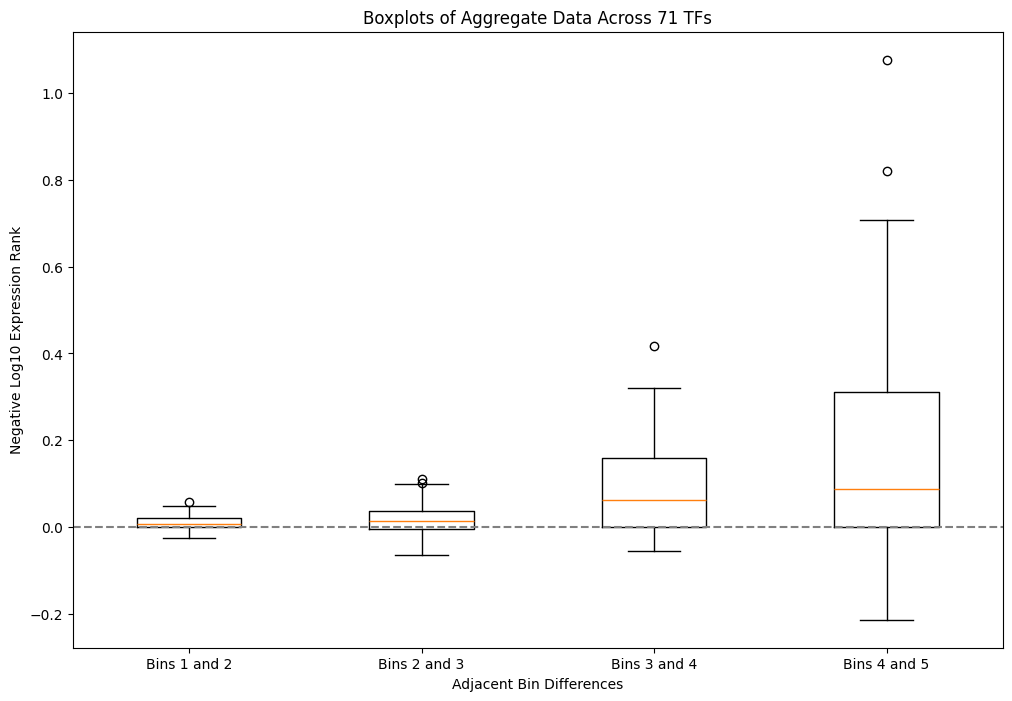

In [328]:
#Run the method on this larger list of TFs
adjacent_differences_box_plot(tfs, boolean_list, "cc", "mcisaac", 5)

This boxplot illustrates the differences in the negative log10 expression rank between adjacent bins across 71 transcription factors (TFs). Each box represents the distribution of these differences between two consecutive bins. For instance, "Bins 1 and 2" shows the difference in expression ranks between the first and second bins, "Bins 2 and 3" between the second and third bins, and so on. In the first boxplot, representing "Bins 1 and 2," the interquartile range (IQR) is very narrow, and the median difference is around zero, indicating little change in expression ranks between these bins for most TFs. 

As we move to "Bins 2 and 3," a similar trend is observed, with the median still close to zero and a narrow IQR, suggesting minimal differences in expression ranks between these bins. However, as we progress to "Bins 3 and 4" and "Bins 4 and 5," we see an increasing spread in the IQR. The median differences for these bins are also higher, especially in "Bins 4 and 5," where the median is significantly above zero. This indicates that for many TFs, there is a noticeable change in expression ranks in the later bins, with the differences becoming more pronounced. The highest quartile in "Bins 4 and 5" indicates that the negative log10 expression rank changes considerably for some TFs, with the top of the boxplot extending to around 0.8, corresponding to a factor of 10^0.8 or approximately 6.3. This means that the expression rank could change by this factor from one bin to the next, demonstrating a significant shift. The presence of outliers further indicates that there are some TFs with even more substantial changes between these bins. 

Overall, this boxplot reveals that the differences between adjacent bins become more pronounced as we move to higher bins. This trend signifies that the expression ranks of TFs change more significantly in the later bins, highlighting a general pattern of increasing variability in the data as we move from earlier to later bins. So, while for some individual TFs the trend may not be evident (like the example shown above) it seems that across the entire dataset, this trend is generally consistent and can serve as a decent relationship that our models can use to learn from the data and result in more accurate predictions.

For a broader look at how the binned means differ, this is an additional method that takes the difference in the binned mean values between the first and last bin for each TF only. Then the data across all TFs is aggregated, and a boxplot is made to visualize the overall difference across all TFs. We can use this to determine further if there truly is a significant increase in the binned means across the first and last bins.

In [341]:
def first_last_bin_difference_box_plot(tfs: List[str], boolean_list: List[bool], binding_source: str, perturbation_source: str, bins: int, pseudocount: Optional[int] = 1) -> None:
    """
    Generates a box plot of the differences between the first and last bins for a list of transcription factors.

    This function processes transcription factor data, calculates the differences between the means of the first and last bins,
    and generates a box plot to visualize these differences across multiple transcription factors.

    Params:
        tfs (List[str]): A list of transcription factor names.
        boolean_list (List[bool]): A list of boolean values indicating whether the data is aggregated for each transcription factor.
        perturbation_source (str): The source of the perturbation data.
        bins (int): The number of bins to create.
        pseudocount (Optional[int]): The constant used in calculating enrichment and pvalues scores to avoid div by zero, default is 1.
        
    Returns:
        None
    """
    # Initialize a list to store differences between the first and last bins for each TF
    first_last_diff_data = []

    # Suppress RuntimeWarnings for the duration of the following operations
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=RuntimeWarning)

        # Iterate over each transcription factor in the list
        for i in range(len(tfs)):
        
            # Process the transcription factor data
            combined_data = process_transcription_factor(str(tfs[i]), boolean_list[i], binding_source, perturbation_source, pseudocount)
        
            # Further process the combined data to calculate ranks and transformations
            plotting_df = process_dataframe(combined_data)
        
            # Create bins for the 'neg_log_rank_binding' column using the specified number of bins
            plotting_df['bin'] = create_bins(plotting_df, 'neg_log_rank_binding', num_bins=bins)
        
            # Calculate the mean of 'neg_expression_rank_log' for each bin
            binned_means = plotting_df.groupby('bin', observed=True)['neg_expression_rank_log'].mean().reset_index()
        
            # Calculate the difference between the first and last bin means
            first_last_diff = binned_means["neg_expression_rank_log"].iloc[-1] - binned_means["neg_expression_rank_log"].iloc[0]
        
            # Append the difference to the first_last_diff_data list
            first_last_diff_data.append(first_last_diff)

    # Remove NaN values from the first_last_diff_data list
    first_last_diff_data = [x for x in first_last_diff_data if not pd.isnull(x)]

    # Create a boxplot for the first and last bin differences
    plt.figure(figsize=(12, 8))
    plt.boxplot(first_last_diff_data)
    plt.axhline(y=0, color='gray', linestyle='--')  # Add a horizontal dotted line at y=0
    plt.xlabel(f'Data from {len(tfs)} TFs')  
    plt.ylabel('Difference in Means between First and Last Bin')  
    plt.title(f'Boxplot of Differences in Means Between First and Last Bins Across {len(tfs)} TFs')  
    plt.show()

Here, we use this method to plot the boxplots for the above TF data.

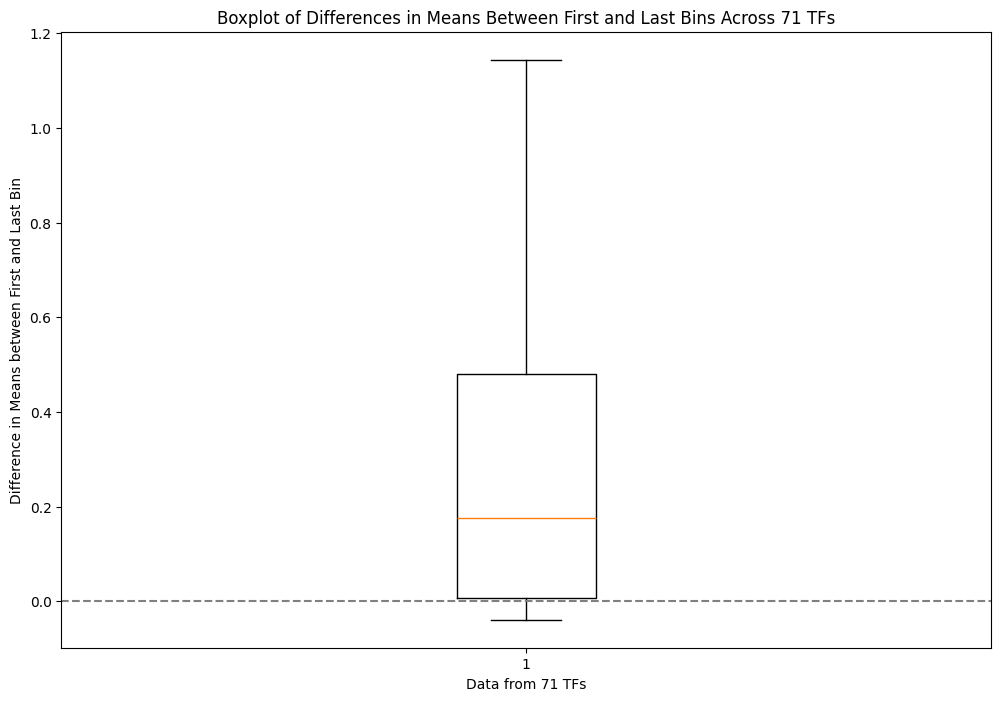

In [330]:
first_last_bin_difference_box_plot(tfs, boolean_list, "cc", "mcisaac", 5)

This boxplot further reinforces the argument that this general trend holds up across transcription factors. The bottom fence of the boxplot is slightly below zero, indicating that the minimum difference between the first and last bins is close to zero. The first quartile is around 0.5, which, when converted from the logarithmic scale (10^0.5), equates to approximately 3.3. This means that moving from the first bin to the last bin, the average response rank decreases by a factor of about 3.3. For example, if the average response rank in the first bin is 1,000, it decreases to around 300 in the last bin. While this shift may not seem drastic, it is significant enough to be noticeable and demonstrates a consistent trend across different TFs. This trend indicates that the response rank generally decreases as we move from the first bin to the last, highlighting a pattern of decreasing average response ranks in the dataset that contributes to the general upward trend we desire.

## **Further Exploration of the Data (after 7/23)**

### Using average ranks instead of normal ranking on the perturbation data

It's interesting to consider whether taking an average ranking might result in a strnger trend being depicted. The motivation for this comes from the fact that in the plots above, the highest value along the y-axis is around -3, and when taking the reverse of the negative log this results in a rank around 1000. If the highest rank is 1000, this implies many ties occuring between data points which can result in a lower resolution of the desired trend. Thus, it is worth exploring whether assigning each gene an average rank across the different timepoints reported in the mcisaac data may produce better rankings. The following methods below will perform this averaging of the ranks on the perturbation data and then combine the perturbation and binding datasets since the original methods do not support the implementation of this ranking method. 

In [331]:
async def process_perturbation_data_async(tf_name: str, perturbation_source: str) -> pd.DataFrame:
    """
    Process perturbation data by retrieving data for different timepoints, ranking genes,
    and calculating the average rank for each gene across timepoints.

    Params:
        tf_name (str): The name of the transcription factor, i.e. "AR080"
        perturbation_source (str): The source of the perturbation data, i.e. "mcisaac"

    Returns:
        pd.DataFrame: A DataFrame containing the genes and their average rankings.
    """
    # Ensure the TF name is in uppercase to maintain consistency
    tf_name_upper = tf_name.upper()
    
    # Initialize API for perturbation data
    expression = ExpressionAPI()
    
    if perturbation_source == "mcisaac":
        timepoints = ["15", "30", "45", "90"]
        all_timepoint_dfs = []

        for time in timepoints:
            source_mapping = {
                "mcisaac": "7",
                "hu_reimann": "5",
                "kemmeren": "6"
            }
            source_number = source_mapping.get(perturbation_source, "unknown")
    
            # Push parameters to retrieve the perturbation data
            if perturbation_source == "mcisaac":
                expression.push_params({"regulator_symbol": tf_name_upper, "source": source_number, "time": "15"})
            else:
                expression.push_params({"regulator_symbol": tf_name_upper, "source": source_number})
            expression_res = await expression.read(retrieve_files=True)
            id = expression_res.get("metadata")["id"][0]
            expression_df = expression_res.get("data").get(str(id))
            expression_df['time'] = time
            expression_df['effect'] = expression_df['effect'].abs()
            all_timepoint_dfs.append(expression_df)

        combined_expression_df = pd.concat(all_timepoint_dfs)

        # Rank genes based on the perturbation effect within each timepoint
        ranked_dfs = []
        for time in timepoints:
            timepoint_df = combined_expression_df[combined_expression_df['time'] == time].copy()
            timepoint_df['rank'] = rankdata(-abs(timepoint_df['effect']), method='average') 
            ranked_dfs.append(timepoint_df)
        
        # Combine ranked dataframes
        ranked_combined_df = pd.concat(ranked_dfs)
        
        avg_ranks = {}
        for gene in ranked_combined_df['target_locus_tag'].unique():
            gene_data = ranked_combined_df[ranked_combined_df['target_locus_tag'] == gene]
            avg_rank = gene_data['rank'].mean()
            avg_effect = gene_data['effect'].mean()
            avg_ranks[gene] = (avg_effect, avg_rank)
        
        avg_ranks_df = pd.DataFrame(list(avg_ranks.items()), columns=['target_locus_tag', 'values'])
        avg_ranks_df[['effect', 'avg_rank']] = pd.DataFrame(avg_ranks_df['values'].tolist(), index=avg_ranks_df.index)
        avg_ranks_df = avg_ranks_df.drop(columns=['values'])
        avg_ranks_df['neg_expression_rank_log'] = -np.log10(avg_ranks_df['avg_rank'])

        return avg_ranks_df

In [332]:
def process_perturbation_data(tf_name: str, perturbation_source: str) -> pd.DataFrame:
    """
    Processes transcription factor data synchronously by invoking an asynchronous function.

    This function runs the asynchronous process_transcription_factor_async function synchronously to handle 
    transcription factor data processing. It retrieves the event loop, runs the asynchronous function, 
    and returns the processed DataFrame.

    Parameters:
        tf_name (str): The name of the transcription factor.
        is_aggregated (bool): A boolean flag indicating whether the data is aggregated.
        perturbation_source (str): The source of the perturbation data.
        pseudocount (int, optional): The constant used in calculating enrichment and pvalues scores to avoid div by zero, default is 1.

    Returns:
        pd.DataFrame: A DataFrame containing the processed transcription factor data.
    """
    loop = asyncio.get_event_loop()
    return loop.run_until_complete(process_perturbation_data_async(tf_name, perturbation_source))

In [283]:
perturbation_avg_ranks_df = process_perturbation_data("ARO80", "mcisaac")

In [284]:
perturbation_avg_ranks_df.head()

,target_locus_tag,effect,avg_rank,neg_expression_rank_log
0,YMR056C,0.0,3127.0,-3.495128
1,YBR085W,0.0,3127.0,-3.495128
2,YJR155W,0.0,3127.0,-3.495128
3,YNL331C,0.0,3127.0,-3.495128
4,YOL165C,0.0,3127.0,-3.495128


In [333]:
async def access_binding_data_async(tf_name: str, is_aggregated: bool, binding_source: str, pseudocount: Optional[int] = 1) -> pd.DataFrame:    
    """
    Process transcription factor data by retrieving and merging binding and perturbation datasets.

    Params:
        tf_name (str): The name of the transcription factor, i.e. "AR080"
        is_aggregated (bool): Indicates whether the data is aggregated. You can check if the TF belongs to the list above.
        perturbation_source (str): The source of the perturbation data, i.e. "mcisaac"
        pseudocount (int, optional): The constant used in calculating enrichment and pvalues scores to avoid div by zero, default is 1.

    Returns:
        pd.DataFrame: A DataFrame containing the combined and processed binding and perturbation data.
    """
    # Ensure the TF name is in uppercase to maintain consistency
    tf_name_upper = tf_name.upper()
    
    # Initialize API for binding data
    pss_api_tf = PromoterSetSigAPI()

    # Access the relevant data depending on whether the data is aggregated or not
    if binding_source == "cc":
        if is_aggregated:
            pss_api_tf.push_params({'regulator_symbol': tf_name_upper, "datasource": "brent_nf_cc", "aggregated": "true"})
        else:
            pss_api_tf.push_params({'regulator_symbol': tf_name_upper, "workflow": "nf_core_callingcards_1_0_0", "data_usable": "pass"})
    elif binding_source == "harbison":
        pss_api_tf.push_params({'regulator_symbol': tf_name_upper, "source": "4"})

    # Asynchronously read the binding data from the API
    tf_pss = await pss_api_tf.read(retrieve_files=True)
    # Get the ID of the retrieved binding data
    id = tf_pss.get("metadata")["id"][0]
    # Extract the binding data using the ID
    binding_df = tf_pss.get("data").get(str(id))

    # Calculate binding rank with average ties method
    if binding_source == "cc":
        binding_df['binding_rank'] = rankdata(binding_df['poisson_pval'], method='average')
    elif binding_source == "harbison":
        binding_df['binding_rank'] = rankdata(binding_df['pval'], method='average')

    # Calculate log transform of the binding rank
    binding_df['neg_log_rank_binding'] = -np.log10(rankdata(binding_df['binding_rank'], method='average'))
    
    return binding_df

In [334]:
def access_binding_data(tf_name: str, is_aggregated: bool, binding_source: str, pseudocount: Optional[int] = 1) -> pd.DataFrame:
    """
    Processes transcription factor data synchronously by invoking an asynchronous function.

    This function runs the asynchronous process_transcription_factor_async function synchronously to handle 
    transcription factor data processing. It retrieves the event loop, runs the asynchronous function, 
    and returns the processed DataFrame.

    Parameters:
        tf_name (str): The name of the transcription factor.
        is_aggregated (bool): A boolean flag indicating whether the data is aggregated.
        perturbation_source (str): The source of the perturbation data.
        pseudocount (int, optional): The constant used in calculating enrichment and pvalues scores to avoid div by zero, default is 1.

    Returns:
        pd.DataFrame: A DataFrame containing the processed transcription factor data.
    """
    loop = asyncio.get_event_loop()
    return loop.run_until_complete(access_binding_data_async(tf_name, is_aggregated, binding_source, pseudocount))

In [298]:
binding_df = access_binding_data("RTG3", False, "cc")

In [299]:
binding_df.head()

,target_id,chr,start,end,strand,experiment_hops,background_hops,background_total_hops,experiment_total_hops,callingcards_enrichment,poisson_pval,hypergeometric_pval,target_locus_tag,target_symbol,record_id,regulator_id,regulator_locus_tag,regulator_symbol,binding_rank,neg_log_rank_binding
0,1,chrI,0,335,+,0,2,103922,10315,0.000000,0.188150,1.000000,YAL069W,unknown_1,6546,140,YBL103C,RTG3,2733.5,-3.436719
1,2,chrI,0,538,+,0,4,103922,10315,0.000000,0.334325,1.000000,YAL068W-A,unknown_2,6546,140,YBL103C,RTG3,3995.0,-3.601517
2,3,chrI,2169,2480,-,1,1,103922,10315,9.158948,0.005544,0.172437,YAL068C,PAU8,6546,140,YBL103C,RTG3,228.5,-2.358886
3,4,chrI,2169,2480,+,1,1,103922,10315,9.158948,0.005544,0.172437,YAL067W-A,unknown_4,6546,140,YBL103C,RTG3,228.5,-2.358886
4,5,chrI,9017,9717,-,0,11,103922,10315,0.000000,0.667712,1.000000,YAL067C,SEO1,6546,140,YBL103C,RTG3,6050.5,-3.781791


In [335]:
def process_and_merge_data(tf_name: str, is_aggregated: bool, binding_source: str, perturbation_source: str, pseudocount: Optional[int] = 1) -> pd.DataFrame:
    """
    Process binding and perturbation data and merge them.

    Params:
        tf_name (str): The name of the transcription factor, i.e. "AR080"
        is_aggregated (bool): Indicates whether the data is aggregated.
        perturbation_source (str): The source of the perturbation data, i.e. "mcisaac"
        pseudocount (int, optional): The constant used in calculating enrichment and pvalues scores to avoid div by zero, default is 1.

    Returns:
        pd.DataFrame: Merged DataFrame with the specified columns.
    """
    binding_df = access_binding_data(tf_name, is_aggregated, binding_source, pseudocount)
    perturbation_df = process_perturbation_data(tf_name, perturbation_source)
    # Merge the dataframes on 'regulator_locus_tag'
    merged_df = pd.merge(binding_df, perturbation_df, on='target_locus_tag')
    
    # Select the desired columns
    result_df = merged_df[['target_locus_tag', 'neg_log_rank_binding', 'neg_expression_rank_log']]    
    return result_df

In [307]:
combined_data = process_and_merge_data("ARO80", False, "cc", "mcisaac")
combined_data.head()

,target_locus_tag,neg_log_rank_binding,neg_expression_rank_log
0,YAL069W,-3.231470,-3.495128
1,YAL068C,-3.056524,-3.495128
2,YAL067C,-3.160769,-3.495128
3,YAL066W,-2.957847,-3.495128
4,YAL065C,-2.548389,-3.495128


In [342]:
def adjacent_differences_box_plot_ranked_data(tfs: List[str], boolean_list: List[bool], binding_source: str, perturbation_source: str, bins: int, pseudocount: Optional[int] = 1) -> None:
    """
    Generates a box plot of the differences between adjacent bins for a list of transcription factors.

    This function processes transcription factor data, calculates differences between the means of adjacent bins,
    and generates a box plot to visualize these differences across multiple transcription factors.

    Params:
        tfs (List[str]): A list of transcription factors that you want to plot.
        boolean_list (List[bool]): A list of boolean values indicating whether the data is aggregated for each transcription factor.
        perturbation_source (str): The source of the perturbation data.
        bins (int): The number of bins to create.
        pseudocount (Optional[int]): The constant used in calculating enrichment and pvalues scores to avoid div by zero, default is 1.

    Returns:
        None
    """
    # Initialize a list of lists to store differences between adjacent bins for each TF
    diff_data = [[] for _ in range(bins - 1)]

    # Suppress RuntimeWarnings for the duration of the following operations
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=RuntimeWarning)

        # Iterate over each transcription factor in the list
        for i in range(len(tfs)):            
            #print(tfs[i])
            plotting_df = process_and_merge_data(str(tfs[i]), boolean_list[i], binding_source, perturbation_source, pseudocount)
            
            # Create bins for the 'neg_log_rank_binding' column using the specified number of bins
            plotting_df['bin'] = create_bins(plotting_df, 'neg_log_rank_binding', num_bins=bins)
            
            # Calculate the mean of 'neg_expression_rank_log' for each bin
            binned_means = plotting_df.groupby('bin', observed=True)['neg_expression_rank_log'].mean().reset_index()
            
            # Initialize a list to store the differences between adjacent bins
            binned_mean_diffs = []
            
            # Calculate the differences between the means of adjacent bins
            for j in range(bins - 1):
                binned_mean_diffs.append(binned_means["neg_expression_rank_log"][j+1] - binned_means["neg_expression_rank_log"][j])
            
            # Append the differences to the corresponding list in diff_data
            for j in range(bins - 1):
                diff_data[j].append(binned_mean_diffs[j])


    # Remove NaN values from all bin difference lists
    diff_data = [[x for x in bin_diff if not pd.isnull(x)] for bin_diff in diff_data]

    # Create a boxplot
    plt.figure(figsize=(12, 8))
    plt.boxplot(diff_data)
    plt.axhline(y=0, color='gray', linestyle='--')  # Add a horizontal dotted line at y=0
    plt.xlabel('Adjacent Bin Differences')  
    plt.ylabel('Negative Log10 Expression Rank')  
    plt.title(f'Boxplots of Aggregate Data Across {len(tfs)} TFs')
    
    # Set x-tick labels dynamically based on the number of bins
    plt.xticks(ticks=range(1, bins), labels=[f'Bins {i+1} and {i+2}' for i in range(bins - 1)])    
    plt.show()

In [343]:
def first_last_bin_difference_box_plot_ranked_data(tfs: List[str], boolean_list: List[bool], binding_source: str, perturbation_source: str, bins: int, pseudocount: Optional[int] = 1) -> None:
    """
    Generates a box plot of the differences between the first and last bins for a list of transcription factors.

    This function processes transcription factor data, calculates the differences between the means of the first and last bins,
    and generates a box plot to visualize these differences across multiple transcription factors.

    Params:
        tfs (List[str]): A list of transcription factor names.
        boolean_list (List[bool]): A list of boolean values indicating whether the data is aggregated for each transcription factor.
        perturbation_source (str): The source of the perturbation data.
        bins (int): The number of bins to create.
        pseudocount (Optional[int]): The constant used in calculating enrichment and pvalues scores to avoid div by zero, default is 1.
        
    Returns:
        None
    """
    # Initialize a list to store differences between the first and last bins for each TF
    first_last_diff_data = []

    # Suppress RuntimeWarnings for the duration of the following operations
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=RuntimeWarning)

        # Iterate over each transcription factor in the list
        for i in range(len(tfs)):
            #print(tfs[i])

            plotting_df = process_and_merge_data(str(tfs[i]), boolean_list[i], binding_source, perturbation_source, pseudocount)
        
            # Create bins for the 'neg_log_rank_binding' column using the specified number of bins
            plotting_df['bin'] = create_bins(plotting_df, 'neg_log_rank_binding', num_bins=bins)
        
            # Calculate the mean of 'neg_expression_rank_log' for each bin
            binned_means = plotting_df.groupby('bin', observed=True)['neg_expression_rank_log'].mean().reset_index()
        
            # Calculate the difference between the first and last bin means
            first_last_diff = binned_means["neg_expression_rank_log"].iloc[-1] - binned_means["neg_expression_rank_log"].iloc[0]
        
            # Append the difference to the first_last_diff_data list
            first_last_diff_data.append(first_last_diff)

    # Remove NaN values from the first_last_diff_data list
    first_last_diff_data = [x for x in first_last_diff_data if not pd.isnull(x)]

    # Create a boxplot for the first and last bin differences
    plt.figure(figsize=(12, 8))
    plt.boxplot(first_last_diff_data)
    plt.axhline(y=0, color='gray', linestyle='--')  # Add a horizontal dotted line at y=0
    plt.xlabel(f'Data from {len(tfs)} TFs')  
    plt.ylabel('Difference in Means between First and Last Bin')  
    plt.title(f'Boxplot of Differences in Means Between First and Last Bins Across {len(tfs)} TFs')  
    plt.show()

In [ ]:
#Here are the 68 TFs we are using that have the 4 timepoints used in the method above available for average ranking
#note: 'FZF1, 'INO4', 'RSF2' were removed due to errors
tfs = ['WTM1', 'MIG2', 'CAT8', 'PDR1', 'PHO4', 'RIM101', 'GZF3', 'VHR1', 'ASH1', 'GAT3','FHL1', 'TEC1', 'SIP3', 'SKN7', 'WTM2','PHO2', 'HAA1', 'ADR1', 'MET31', 'CRZ1', 'RPH1', 'CHA4', 'CAD1', 'ZAP1', 'SKO1', 'ACA1', 'HAP2', 'HAP3', 'HAP5', 'ERT1', 'TOG1', 'MET4', 'PPR1', 'RTG1', 'GLN3', 'MOT3', 'AFT1', 'GIS1', 'CBF1', 'SUM1', 'MSN2', 'DAL80', 'UPC2','RTG3', 'GAL80', 'RME1', 'HIR2', 'SIP4', 'GCR1', 'HAP4', 'UME1', 'MET32', 'USV1', 'MGA1', 'CIN5', 'ROX1','XBP1', 'ZNF1', 'YHP1', 'RDR1', 'PDR3', 'RLM1', 'SFL1', 'SMP1', 'SUT2', 'HAC1', 'PHD1', 'ARO80']
boolean_list = [True]*56+[False] * 12

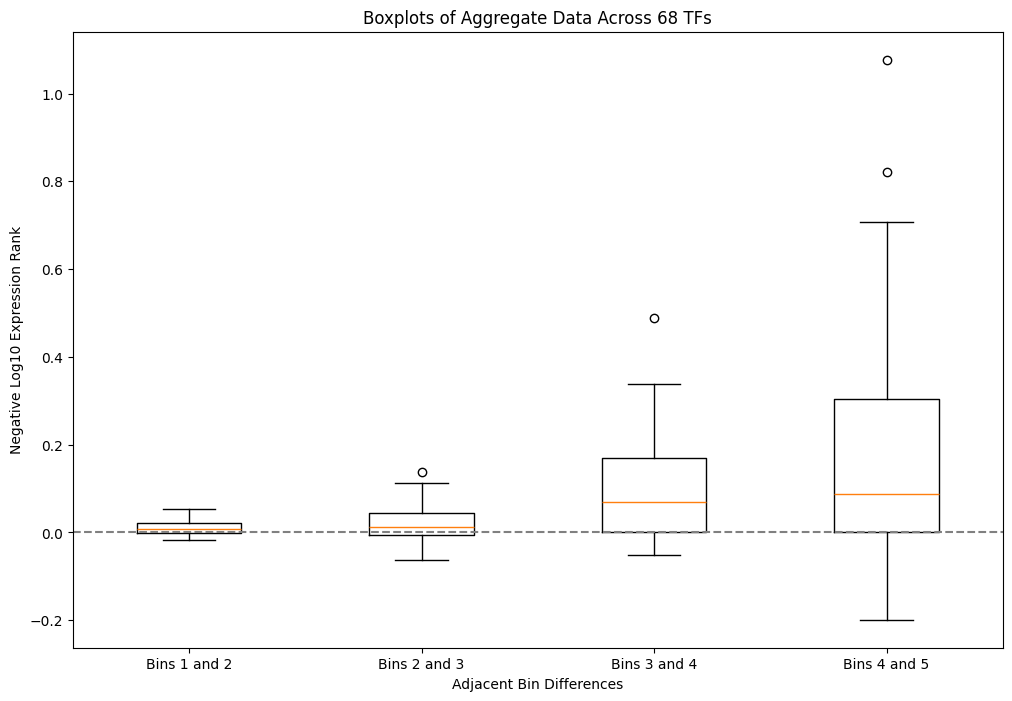

In [345]:
adjacent_differences_box_plot_ranked_data(tfs, boolean_list, "cc", "mcisaac", 5)

In comparing the regular ranking method to the average ranking method using these boxplots, it seems that the regular ranking method produces a more satisfactory trend overall. Most notably is the comparison between the two ranking methods in Bins 4 and 5, where the upper quartile by regular ranking is substantially higher han the upper quartile in the boxplot from average ranking. Thus, it seems that using the regular ranking method may produce more useful results overall, and also is simpler to utilize as opposed to the average ranking method.

ERROR:asyncio:Task exception was never retrieved
future: <Task finished name='Task-15682' coro=<process_perturbation_data_async() done, defined at /var/folders/25/6s7q5c9j40373whzd3q5s20m0000gn/T/ipykernel_6092/3270395016.py:1> exception=KeyboardInterrupt()>
Traceback (most recent call last):
  File "/Users/ericjia/yeastdnnexplorer/.venv/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3577, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/var/folders/25/6s7q5c9j40373whzd3q5s20m0000gn/T/ipykernel_6092/2798669504.py", line 1, in <module>
    combined_data = process_and_merge_data("ARO80", False, "cc", "mcisaac")
                    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/25/6s7q5c9j40373whzd3q5s20m0000gn/T/ipykernel_6092/2270130694.py", line 15, in process_and_merge_data
    perturbation_df = process_perturbation_data(tf_name, perturbation_source)
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

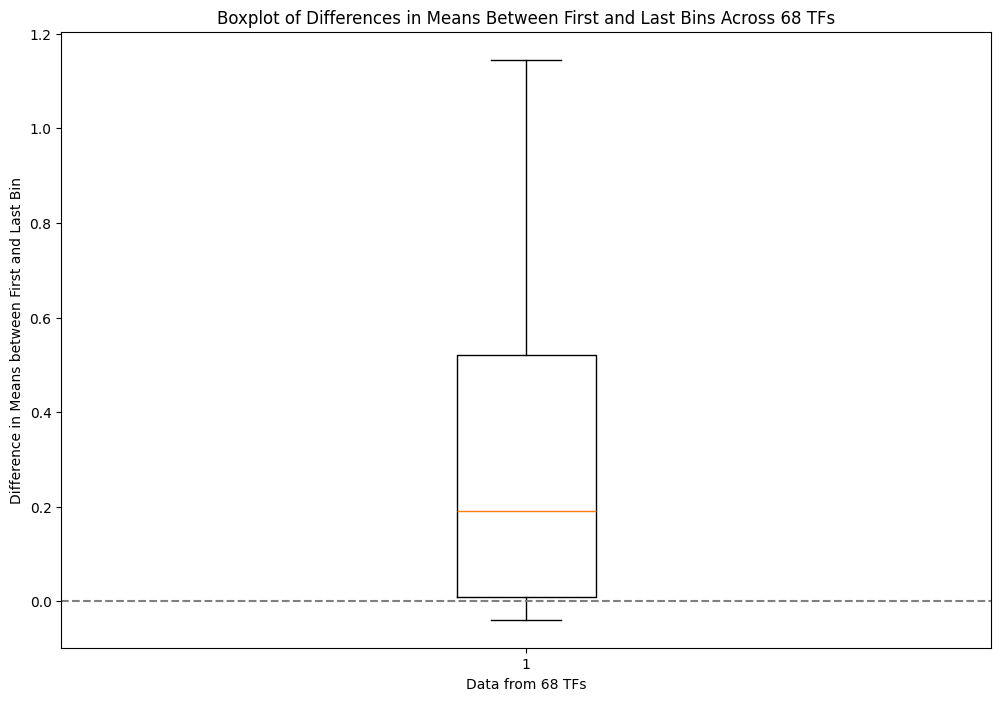

In [346]:
first_last_bin_difference_box_plot_ranked_data(tfs, boolean_list, "cc","mcisaac", 5)

Similarly, looking at this boxplot of the first and last binned mean differences it seems that the median is also lower than the original boxplot using the regular ranking. In general, it seems like using the average ranking method doesn't necessarily yield more desirable results. Given the additional processing it takes and the extra complications it introduces, it is likely not worth utilizing as the improvements to the boxplots are marginal.

### Using the Kemmeren perturbation data instead of mcisaac

We also want to consider how whether this trend is seen when using different datasets. Here, we explore using the kemmeren perturbation dataset instead of mcisaac at 15 minutes (regular ranking) to observe how the trend will hold up when using this alternative dataset. We also compare the boxplots of the two to provide a better picture of which may produce better observable trends.

In [ ]:
#This is the list of 78 TFs that appear in both the mcisaac and kemmeren perturbation datasets as well as the Calling Cards binding data.
tfs = ['WTM1', 'MIG2', 'CAT8', 'PDR1', 'PHO4', 'RIM101', 'GZF3', 'VHR1', 'ASH1', 'GAT3', 'TEC1', 'SIP3', 'SKN7', 'WTM2','PHO2', 'HAA1', 'ADR1', 'MET31', 'CRZ1', 'RPH1', 'CHA4', 'CAD1', 'ZAP1', 'SKO1', 'ACA1', 'FZF1', 'HAP2', 'HAP3', 'HAP5','INO4', 'ERT1', 'TOG1','PPR1', 'RTG1', 'GLN3', 'MOT3', 'AFT1', 'GIS1', 'CBF1', 'SUM1', 'MSN2', 'DAL80', 'UPC2','RTG3', 'GAL80', 'RSF2', 'RME1', 'HIR2', 'SIP4','HAP4', 'UME1', 'MET32', 'USV1', 'MGA1', 'CIN5', 'ROX1', 'TUP1','GAL3', 'ECM23','IXR1', 'MTH1','DOT6','ASK10','DAT1','INO2','ABF2','XBP1','ZNF1', 'YHP1','RDR1','PDR3', 'RLM1', 'SFL1','SMP1', 'SUT2','PHD1','ARO80','HAC1']
boolean_list = [True] * 66 + [False] * 12

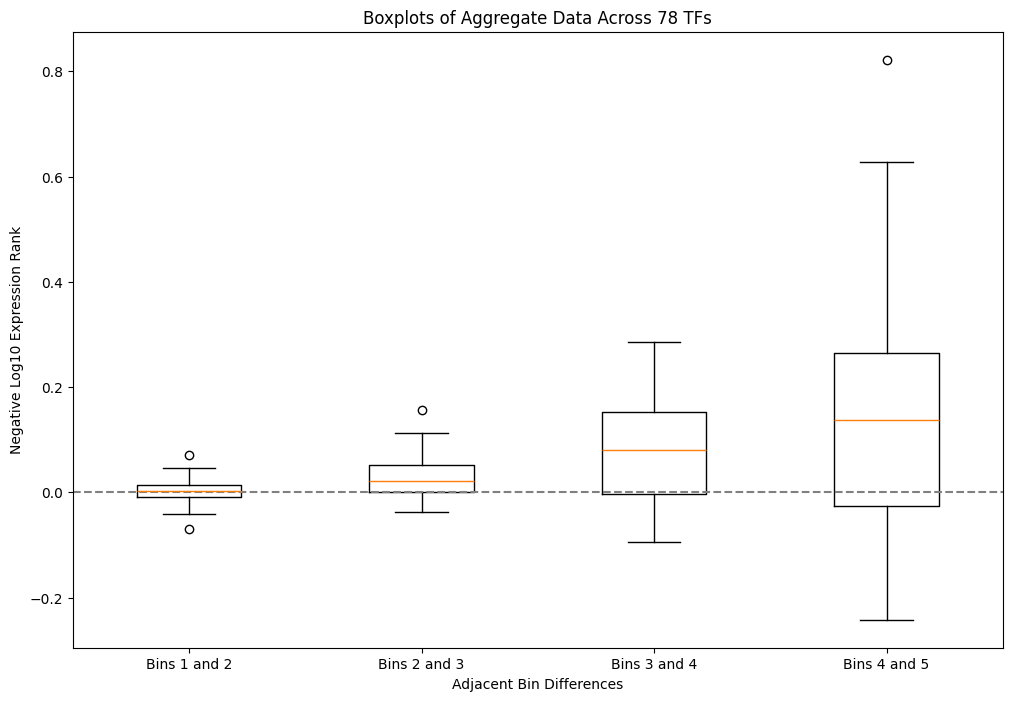

In [351]:
adjacent_differences_box_plot(tfs, boolean_list, "cc", "kemmeren", 5)

Here is the boxplot of the adjacent bin mean differences. This looks promising as the later two adjacent bin differences seem to show a generally positive increase, suggesting that the trend is still observed when switching the perturbation data. This is also good because it confirms that across different datasets where experimental conditions may vary, this trend is still observable and holds up.

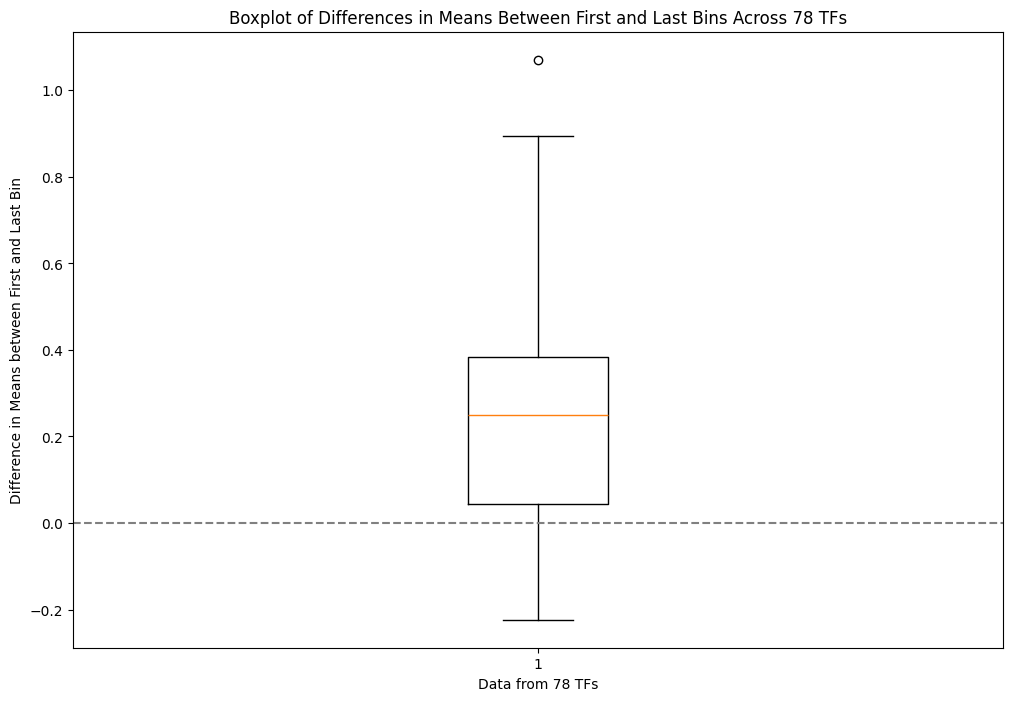

In [352]:
first_last_bin_difference_box_plot(tfs, boolean_list, "cc", "kemmeren", 5)

Similarly, here is the boxplot of the mean differences between the first and last bins, which also shows that in general, there is an increase in the negative log rank of the expression data. This further supports the general trend being observed. Now, since we have shown there is an observable trend, it is good to compare it to mcisaac to see which may produce better trends when using the same CallingCards binding data.

In [387]:
def adjacent_differences_store_data(tfs: List[str], boolean_list: List[bool], binding_source: str, perturbation_sources: List[str], bins: int, pseudocount: Optional[int] = 1) -> dict:
    """
    Stores the differences between adjacent bins for a list of transcription factors.

    This function processes transcription factor data, calculates differences between the means of adjacent bins,
    and stores these differences across multiple transcription factors.

    Params:
        tfs (List[str]): A list of transcription factors that you want to plot.
        boolean_list (List[bool]): A list of boolean values indicating whether the data is aggregated for each transcription factor.
        perturbation_sources (List[str]): A list of sources of the perturbation data.
        bins (int): The number of bins to create.
        pseudocount (Optional[int]): The constant used in calculating enrichment and pvalues scores to avoid div by zero, default is 1.

    Returns:
        dict: A dictionary containing the stored data for each perturbation source.
    """
    # Initialize a dictionary to store differences between adjacent bins for each perturbation source
    diff_data = {source: [[] for _ in range(bins - 1)] for source in perturbation_sources}

    # Suppress RuntimeWarnings for the duration of the following operations
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=RuntimeWarning)

        # Iterate over each transcription factor in the list
        for i in range(len(tfs)):
            for source in perturbation_sources:
                # Process the transcription factor data
                combined_data = process_transcription_factor(str(tfs[i]), boolean_list[i], binding_source, source, pseudocount)
                
                # Further process the combined data to calculate ranks and transformations
                plotting_df = process_dataframe(combined_data)
                
                # Create bins for the 'neg_log_rank_binding' column using the specified number of bins
                plotting_df['bin'] = create_bins(plotting_df, 'neg_log_rank_binding', num_bins=bins)
                
                # Calculate the mean of 'neg_expression_rank_log' for each bin
                binned_means = plotting_df.groupby('bin', observed=True)['neg_expression_rank_log'].mean().reset_index()
                
                # Initialize a list to store the differences between adjacent bins
                binned_mean_diffs = []
                
                # Calculate the differences between the means of adjacent bins
                for j in range(bins - 1):
                    binned_mean_diffs.append(binned_means["neg_expression_rank_log"][j+1] - binned_means["neg_expression_rank_log"][j])
                
                # Append the differences to the corresponding list in diff_data
                for j in range(bins - 1):
                    diff_data[source][j].append(binned_mean_diffs[j])

    # Remove NaN values from all bin difference lists
    for source in diff_data:
        diff_data[source] = [[x for x in bin_diff if not pd.isnull(x)] for bin_diff in diff_data[source]]

    return diff_data

In [388]:
def compare_adjacent_stored_data_box_plots(stored_data_list: List[dict], labels: List[str]) -> None:
    """
    Generates a box plot comparing multiple sets of stored data and adds a horizontal line at y=0.

    Params:
        stored_data_list (List[dict]): A list of dictionaries containing stored data for each perturbation source.
        labels (List[str]): A list of labels corresponding to each set of stored data.

    Returns:
        None
    """
    plt.figure(figsize=(20, 13))
    boxplot_data = []
    source_labels = []
    bin_labels = []

    for j in range(4):
        for idx, stored_data in enumerate(stored_data_list):
            for source, data in stored_data.items():
                boxplot_data.append(data[j])
                source_labels.append(labels[idx])
                bin_labels.append(f'Bins {j+1} and {j+2}')

    box_positions = list(range(1, len(boxplot_data) + 1))

    plt.boxplot(boxplot_data, positions=box_positions, widths=0.6)
    plt.axhline(y=0, color='gray', linestyle='--')  # Add a horizontal dotted line at y=0

    # Set the primary x-axis labels (perturbation sources)
    plt.xticks(ticks=box_positions, labels=source_labels, rotation=90, ha='center')

    # Add bin labels below the primary x-axis
    ax = plt.gca()
    ax2 = ax.secondary_xaxis('bottom')
    unique_bins = list(set(bin_labels))
    bin_label_positions = []
    for unique_bin in unique_bins:
        positions = [box_positions[i] for i, bin_label in enumerate(bin_labels) if bin_label == unique_bin]
        center_position = sum(positions) / len(positions)
        bin_label_positions.append(center_position)
    ax2.set_xticks(bin_label_positions)
    ax2.set_xticklabels(unique_bins, rotation=0, ha='center', weight='bold', fontsize=12)
    
    # Adjust the position of the primary x-axis labels and the secondary x-axis labels
    plt.subplots_adjust(bottom=0.3)  # Adjust bottom to make space for source labels
    ax.tick_params(axis='x', which='major', pad=25)  # Increase the padding for the source labels

    plt.xlabel('Perturbation Sources and Bins')  
    plt.ylabel('Difference in Binned Means')  
    plt.title('Comparison of Adjacent Binned Mean Differences Between Perturbation Sources')

    plt.show()

In [356]:
#this is the list of TFs that appears in all three datasets as well as the Calling Cards data:
tfs = ['WTM1','MIG2','CAT8','PDR1','PHO4','RIM101','GZF3','ASH1','GAT3','TEC1','SIP3','SKN7','WTM2','PHO2','HAA1','ADR1','MET31','CRZ1','RPH1','CHA4','CAD1','ZAP1','SKO1','ACA1','FZF1','HAP2','HAP3','HAP5','INO4','ERT1','TOG1','PPR1','RTG1','GLN3','MOT3','AFT1','CBF1','SUM1','MSN2','DAL80','UPC2','RTG3','GAL80','RSF2','RME1','HIR2','SIP4','HAP4','UME1','MET32','USV1','MGA1','CIN5','ROX1','XBP1','ZNF1','YHP1','RDR1','PDR3','RLM1','SFL1','SMP1','SUT2','HAC1','PHD1','ARO80']
boolean_list = [True]*54 + [False]*12
cc_kemmeren_adjacent_data = adjacent_differences_store_data(tfs, boolean_list, "cc", perturbation_sources = ["kemmeren"], bins = 5)
cc_mcisaac_adjacent_data = adjacent_differences_store_data(tfs, boolean_list, "cc", perturbation_sources = ["mcisaac"], bins = 5)

In [362]:
stored_data_list = [cc_kemmeren_adjacent_data, cc_mcisaac_adjacent_data]
labels = ['kemmeren', 'mcisaac']

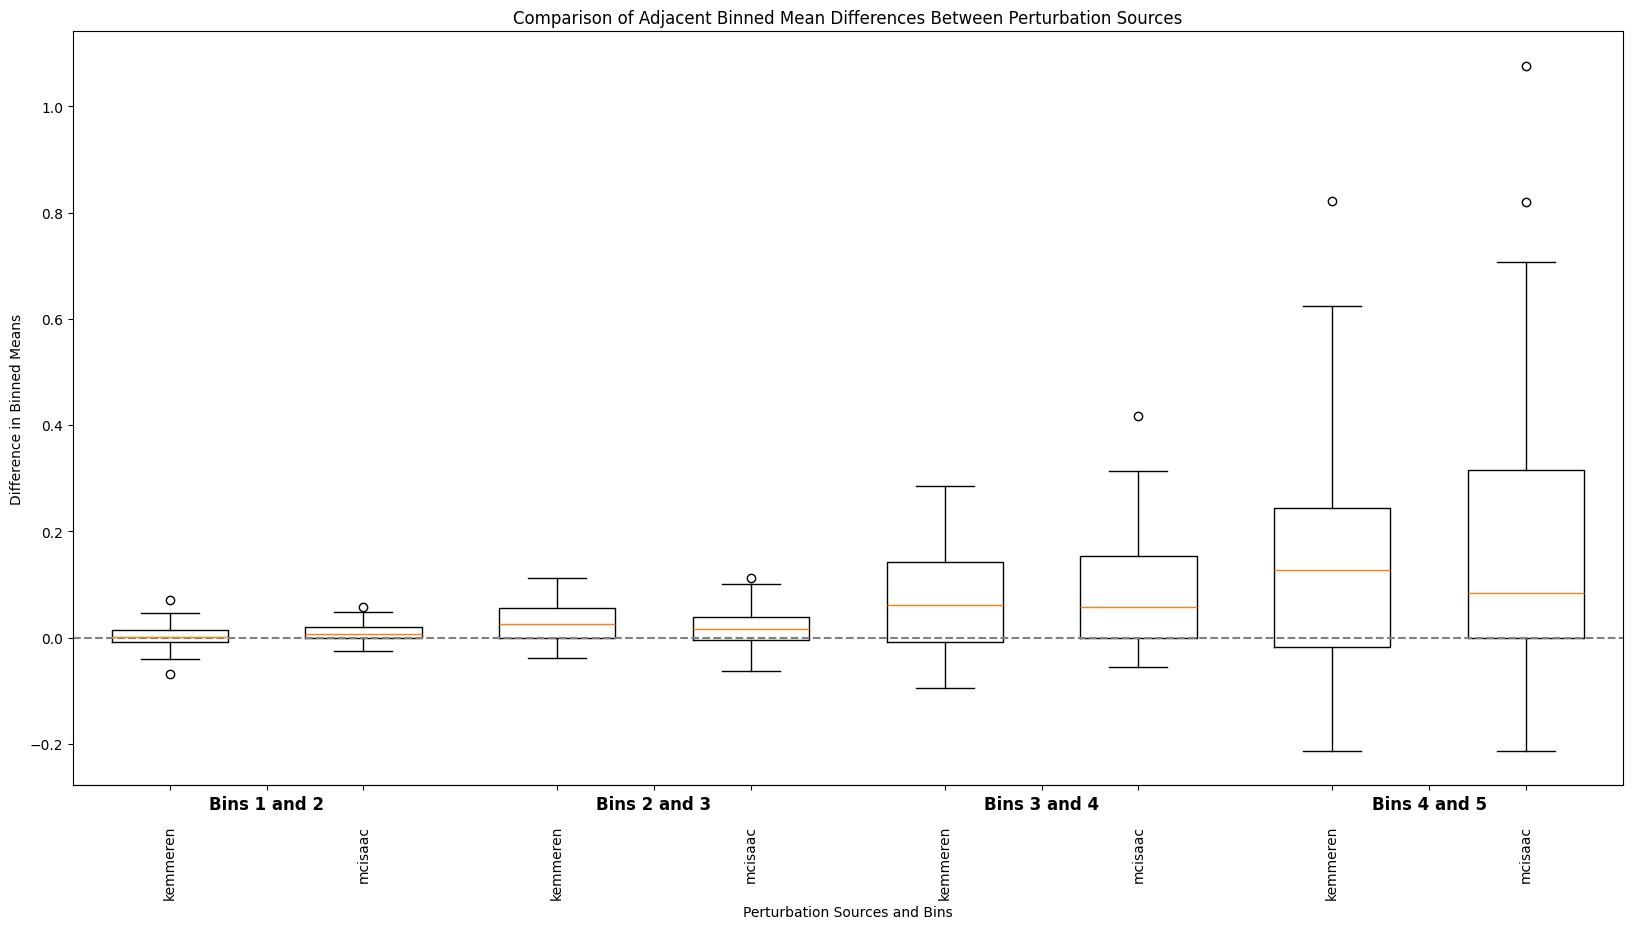

In [363]:
compare_adjacent_stored_data_box_plots(stored_data_list, labels)

Here is a comparison between the mcisaac and kemmeren boxplots. While the first two adjacent bin differences depict roughly the same relationship, it appears that in the later two adjacent bins differences there is more of an observable difference. For Bins 3 and 4, both boxplots exhibit roughly the same upper and lower quartiles, but the kemmeren boxplot has a slightly higher median. With Bins 4 and 5, kemmeren exhibits a substantially higher median, but mcisaac has a higher maximum with greater variance. 

It will help to also compare the boxplots between the first and last bin mean differences, and we will do so below.

In [389]:
def first_last_bin_difference_box_plot_comparisons(tfs: List[str], boolean_list: List[bool], binding_source: str, perturbation_sources: List[str], bins: int, pseudocount: Optional[int] = 1) -> dict:
    """
    Generates a box plot of the differences between the first and last bins for a list of transcription factors.

    This function processes transcription factor data, calculates differences between the means of the first and last bins,
    and generates a box plot to visualize these differences across multiple transcription factors.

    Params:
        tfs (List[str]): A list of transcription factors that you want to plot.
        boolean_list (List[bool]): A list of boolean values indicating whether the data is aggregated for each transcription factor.
        perturbation_sources (List[str]): A list of sources of the perturbation data.
        bins (int): The number of bins to create.
        pseudocount (Optional[int]): The constant used in calculating enrichment and pvalues scores to avoid div by zero, default is 1.

    Returns:
        dict: A dictionary containing the stored data for each perturbation source.
    """
    # Initialize a dictionary to store differences between the first and last bins for each perturbation source
    diff_data = {source: [] for source in perturbation_sources}

    # Suppress RuntimeWarnings for the duration of the following operations
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=RuntimeWarning)

        # Iterate over each transcription factor in the list
        for i in range(len(tfs)):
            for source in perturbation_sources:
                # Process the transcription factor data
                combined_data = process_transcription_factor(str(tfs[i]), boolean_list[i], binding_source, source, pseudocount)
                
                # Further process the combined data to calculate ranks and transformations
                plotting_df = process_dataframe(combined_data)
                
                # Create bins for the 'neg_log_rank_binding' column using the specified number of bins
                plotting_df['bin'] = create_bins(plotting_df, 'neg_log_rank_binding', num_bins=bins)
                
                # Calculate the mean of 'neg_expression_rank_log' for each bin
                binned_means = plotting_df.groupby('bin', observed=True)['neg_expression_rank_log'].mean().reset_index()
                
                # Calculate the difference between the first and last bin means
                first_last_diff = binned_means["neg_expression_rank_log"].iloc[-1] - binned_means["neg_expression_rank_log"].iloc[0]
                
                # Append the difference to the corresponding list in diff_data
                diff_data[source].append(first_last_diff)

    # Remove NaN values from all bin difference lists
    for source in diff_data:
        diff_data[source] = [x for x in diff_data[source] if not pd.isnull(x)]

    return diff_data

In [390]:
def compare_first_and_last_stored_data_box_plots(stored_data_list: List[dict], labels: List[str]) -> None:
    """
    Generates a box plot comparing multiple sets of stored data.

    Params:
        stored_data_list (List[dict]): A list of dictionaries containing stored data for each perturbation source.
        labels (List[str]): A list of labels corresponding to each set of stored data.

    Returns:
        None
    """
    plt.figure(figsize=(10, 6))
    boxplot_data = []
    xtick_labels = []

    for idx, stored_data in enumerate(stored_data_list):
        for source, data in stored_data.items():
            boxplot_data.append(data)
            xtick_labels.append(f'{labels[idx]}')

    plt.boxplot(boxplot_data, widths=0.6)
    plt.axhline(y=0, color='gray', linestyle='--')  # Add a horizontal dotted line at y=0
    plt.xlabel('Perturbation Sources')  
    plt.ylabel('Difference in Binned Means Between First and Last Bin')  
    plt.title('Comparison of First and Last Bin Differences Across Multiple Groups')
    
    plt.xticks(ticks=range(1, len(xtick_labels) + 1), labels=xtick_labels, rotation=90)
    plt.show()

In [367]:
#using the same TF list as above, let's plot the differences between these two datasets
cc_kemmeren_first_last_data = first_last_bin_difference_box_plot_comparisons(tfs, boolean_list, "cc", perturbation_sources = ["kemmeren"], bins = 5)
cc_mcisaac_first_last_data = first_last_bin_difference_box_plot_comparisons(tfs, boolean_list, "cc", perturbation_sources = ["mcisaac"], bins = 5)

In [368]:
stored_data_list = [cc_kemmeren_first_last_data, cc_mcisaac_first_last_data]
labels = ["kemmeren", 'mcisaac']

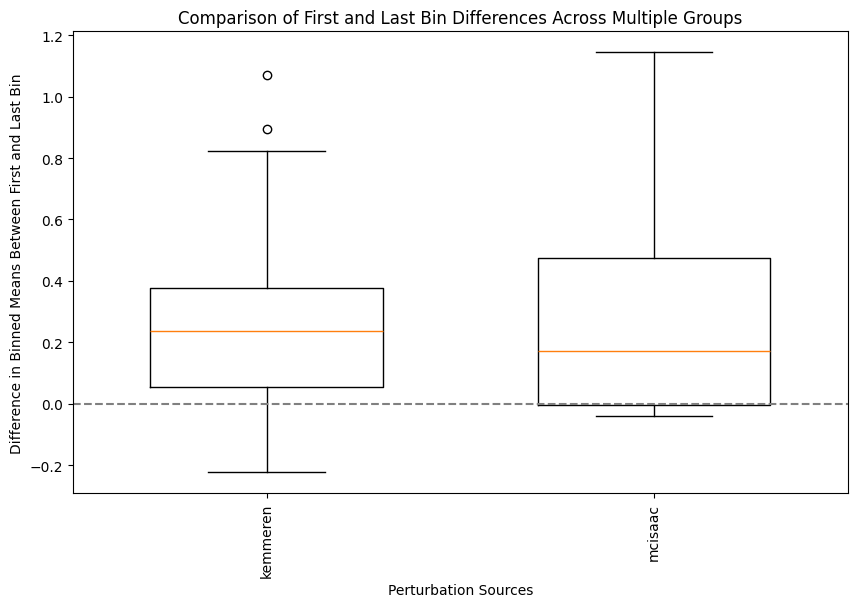

In [369]:
compare_first_and_last_stored_data_box_plots(stored_data_list, labels)

This comparison actually helps illuminate the overall trends better. Here, the kemmeren data has both a smaller spread and a higher median as opposed to the mcisaac data. However, it has a significantly lower minimum and maximum as opposed to the mcisaac data. Thus, it may be important to consider which dataset is more useful. There doesn't seem to be a clear answer here, so further investigation could help.

### Which method of ranking the TF binding data yields the best trends?

On the binding side, it's worth further exploring the which ranking method is most optimal. We essentially have 3 options: using the enrichment values, poisson pvalues, or hypergeometric pvalues to rank the binding data by. We have currently been ranking the data according to the poisson pvalues, but given that multiple experiment outcomes can produce the same pvalue, resulting to many ties that may decrease the resolution of the trends we are graphing, it is worth considering if the other two ranking methods can produce higher average ranks that result in less ties, hopefully producing more observable trends. The boxplots below are generated by taking the highest rank by each of the three methods on each TF, and generating this data across the entire Calling Cards TF pool to determine which may produce the highest average ranks.

In [412]:
async def fetch_binding_data_async(tf_name: str, is_aggregated: bool, pseudocount: int = 1) -> pd.DataFrame:
    """
    Fetch binding data for a transcription factor and compute the 'effect' size.

    Params:
        tf_name (str): The name of the transcription factor.
        is_aggregated (bool): Indicates whether the data is aggregated.
        pseudocount (int): The constant used in calculating enrichment scores to avoid div by zero, default is 1.

    Returns:
        pd.DataFrame: A DataFrame containing the binding data with 'effect' computed.
    """
    tf_name_upper = tf_name.upper()
    pss_api_tf = PromoterSetSigAPI()
    
    if is_aggregated:
        pss_api_tf.push_params({'regulator_symbol': tf_name_upper, "datasource": "brent_nf_cc", "aggregated": "true"})
    else:
        pss_api_tf.push_params({'regulator_symbol': tf_name_upper, "workflow": "nf_core_callingcards_1_0_0", "data_usable": "pass"})
    
    tf_pss = await pss_api_tf.read(retrieve_files=True)
    id = tf_pss.get("metadata")["id"][0]
    binding_df = tf_pss.get("data").get(str(id))

    binding_data = binding_df
    binding_data.rename(columns={"callingcards_enrichment": "effect"}, inplace=True)
    binding_data['effect'] = (binding_data['experiment_hops'] / binding_data['experiment_total_hops']) / \
                             ((binding_data['background_hops'] + pseudocount) / binding_data['background_total_hops'])

    return binding_data

def fetch_binding_data(tf_name: str, is_aggregated: bool, pseudocount: int = 1) -> pd.DataFrame:
    loop = asyncio.get_event_loop()
    return loop.run_until_complete(fetch_binding_data_async(tf_name, is_aggregated, pseudocount))

def assign_rankings(binding_data: pd.DataFrame) -> pd.DataFrame:
    """
    Assign rankings to the binding data based on 'effect', 'poisson_pvalue', and 'hypergeometric_pvalue'.

    Params:
        binding_data (pd.DataFrame): The binding data to rank.

    Returns:
        pd.DataFrame: A DataFrame with rankings assigned.
    """
    binding_data['rank_effect'] = binding_data['effect'].rank(ascending=False, method='average')
    binding_data['rank_poisson'] = binding_data['poisson_pval'].rank(ascending=True, method='average')
    binding_data['rank_hypergeometric'] = binding_data['hypergeometric_pval'].rank(ascending=True, method='average')

    return binding_data

def find_smallest_ranks(binding_data: pd.DataFrame) -> pd.Series:
    """
    Find the smallest rank for each ranking method.

    Params:
        binding_data (pd.DataFrame): The binding data with rankings.

    Returns:
        pd.Series: A Series containing the smallest ranks for each method.
    """
    smallest_ranks = {
        'rank_effect': binding_data['rank_effect'].min(),
        'rank_poisson': binding_data['rank_poisson'].min(),
        'rank_hypergeometric': binding_data['rank_hypergeometric'].min()
    }

    return pd.Series(smallest_ranks)

def compare_tf_rankings(tfs: list, bool_list: list, binding_source: str, pseudocount: int = 1):
    """
    Compare the smallest ranks across multiple transcription factors and generate boxplots.

    Params:
        tfs (list): A list of transcription factor names.
        is_aggregated (bool): Indicates whether the data is aggregated.
        pseudocount (int): The constant used in calculating enrichment scores to avoid div by zero, default is 1.
    """
    all_ranks_effect = []
    all_ranks_poisson = []
    all_ranks_hypergeometric = []

    for i in range(len(tfs)):
        binding_data = fetch_binding_data(tfs[i], bool_list[i], pseudocount)
        ranked_data = assign_rankings(binding_data)
        smallest_ranks = find_smallest_ranks(ranked_data)
        
        all_ranks_effect.append(smallest_ranks['rank_effect'])
        all_ranks_poisson.append(smallest_ranks['rank_poisson'])
        all_ranks_hypergeometric.append(smallest_ranks['rank_hypergeometric'])

    # Generate boxplots
    plt.figure(figsize=(12, 8))
    plt.boxplot([all_ranks_effect, all_ranks_poisson, all_ranks_hypergeometric], labels=['Effect', 'Poisson p-value', 'Hypergeometric p-value'])
    plt.axhline(y=0, color='gray', linestyle='--')  # Add a horizontal dotted line at y=0
    plt.xlabel('Ranking Method')
    plt.ylabel('Smallest Rank')
    plt.title(f'Comparison of Smallest Ranks Across TFs on {binding_source} data')
    plt.show()

/var/folders/25/6s7q5c9j40373whzd3q5s20m0000gn/T/ipykernel_6092/2867473121.py:94: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([all_ranks_effect, all_ranks_poisson, all_ranks_hypergeometric], labels=['Effect', 'Poisson p-value', 'Hypergeometric p-value'])


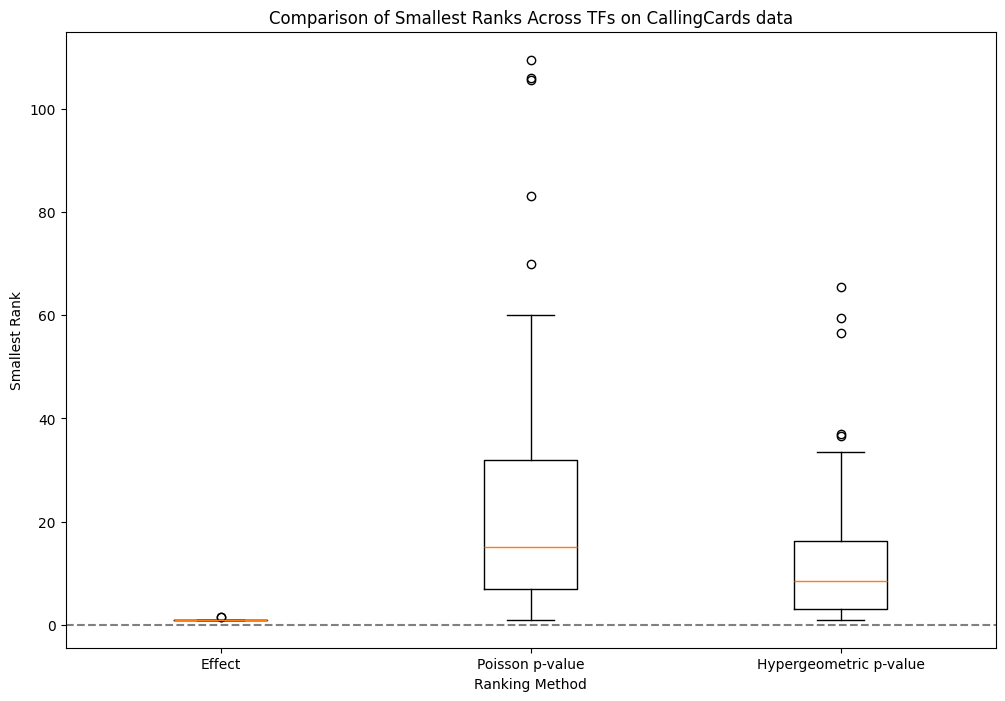

In [413]:
#Using this on CallingCards Data
tfs = ['WTM1', 'MIG2', 'CAT8', 'PDR1', 'PHO4', 'RIM101', 'GZF3', 'VHR1', 'ASH1', 'GAT3','FHL1', 'TEC1', 'SIP3', 'SKN7', 'WTM2','PHO2', 'HAA1', 'ADR1', 'MET31', 'CRZ1', 'RPH1', 'CHA4', 'CAD1', 'ZAP1', 'SKO1', 'ACA1', 'FZF1', 'HAP2', 'HAP3', 'HAP5','INO4', 'ERT1', 'TOG1', 'MET4', 'PPR1', 'RTG1', 'GLN3', 'MOT3', 'AFT1', 'GIS1', 'CBF1', 'SUM1', 'MSN2', 'DAL80', 'UPC2','RTG3', 'GAL80', 'RSF2', 'RME1', 'HIR2', 'SIP4', 'GCR1', 'HAP4', 'UME1', 'MET32', 'USV1', 'MGA1', 'CIN5', 'ROX1','XBP1', 'ZNF1', 'YHP1', 'RDR1', 'PDR3', 'RLM1', 'SFL1', 'SMP1', 'SUT2', 'HAC1', 'PHD1', 'ARO80']
#Assigning the correct boolean to each TF based on whether the TF contains aggregated data in the database or not
boolean_list = [True] * 59 + [False] * 12

compare_tf_rankings(tfs, boolean_list, "CallingCards")

This is quite interesting. Immediately, your attention might be drawn to the leftmost boxplot for the enrichment values. Since the y-axis is plotting the smallest rank across each TF, it appears that for the effect boxplot, almost the entire TF dataset produces a rank of 1 as the smallest rank. This means that there is a clear difference in enrichment values that reuslts in a higher rank as opposed to the other two pvalue methods, whose medians and lower quartiles hover closer to 10 than 0, suggesting greater ties at the top resulting in larger highest ranks. Seeing that using enrichment values to rank produces higher ranks in general, it is worth plotting the original data but using the negative log rank of the enrichment on the x-axis to see how the boxplots will differ. We do that now.

Here we are plotting the original boxplots but ranking the binding data using the enrichment values instead of the poisson pvalues to see how the boxplots will change. First, we need to make a slight change to the process_dataframe method so that it ranks the enrichment scores instead of the pvalues

In [370]:
def process_dataframe(df: pd.DataFrame) -> pd.DataFrame:
    """
    Processes a DataFrame further by calculating ranks and log transformations for expression and binding data to elucidate certain trends.

    Params:
        df (pd.DataFrame): The input DataFrame containing 'effect_perturbation' and 'pvalue_binding' columns.

    Returns:
        pd.DataFrame:A DataFrame that includes the original data along with new columns for expression ranks, log-transformed ranks, 
                     binding ranks, and is sorted by the negative log-transformed binding rank.
    """
    # Calculate expression rank with average ties method
    df['expression_rank'] = rankdata(-abs(df['effect_perturbation']), method='average')

    # Log transform the expression rank
    df['neg_expression_rank_log'] = -np.log10(df['expression_rank'])

    # Calculate binding rank with average ties method
    df['binding_rank'] = rankdata(-df['effect_binding'], method='average')

    # Calculate log transform of the binding rank
    df['neg_log_rank_binding'] = -np.log10(rankdata(df['binding_rank'], method='average'))

    # Select specific columns
    plotting_df = df[['effect_perturbation', 'expression_rank', 'neg_expression_rank_log', 
                      'pvalue_binding', 'binding_rank', 'neg_log_rank_binding']]

    # Arrange (sort) by neg_log_rank_binding in descending order
    plotting_df = plotting_df.sort_values(by='neg_log_rank_binding', ascending=False)
    
    return plotting_df

In [375]:
tfs = ['WTM1', 'MIG2', 'CAT8', 'PDR1', 'PHO4', 'RIM101', 'GZF3', 'VHR1', 'ASH1', 'GAT3','FHL1', 'TEC1', 'SIP3', 'SKN7', 'WTM2','PHO2', 'HAA1', 'ADR1', 'MET31', 'CRZ1', 'RPH1', 'CHA4', 'CAD1', 'ZAP1', 'SKO1', 'ACA1', 'FZF1', 'HAP2', 'HAP3', 'HAP5','INO4', 'ERT1', 'TOG1', 'MET4', 'PPR1', 'RTG1', 'GLN3', 'MOT3', 'AFT1', 'GIS1', 'CBF1', 'SUM1', 'MSN2', 'DAL80', 'UPC2','RTG3', 'GAL80', 'RSF2', 'RME1', 'HIR2', 'SIP4', 'GCR1', 'HAP4', 'UME1', 'MET32', 'USV1', 'MGA1', 'CIN5', 'ROX1','XBP1', 'ZNF1', 'YHP1', 'RDR1', 'PDR3', 'RLM1', 'SFL1', 'SMP1', 'SUT2', 'HAC1', 'PHD1', 'ARO80']
#Assigning the correct boolean to each TF based on whether the TF contains aggregated data in the database or not
boolean_list = [True] * 59 + [False] * 12

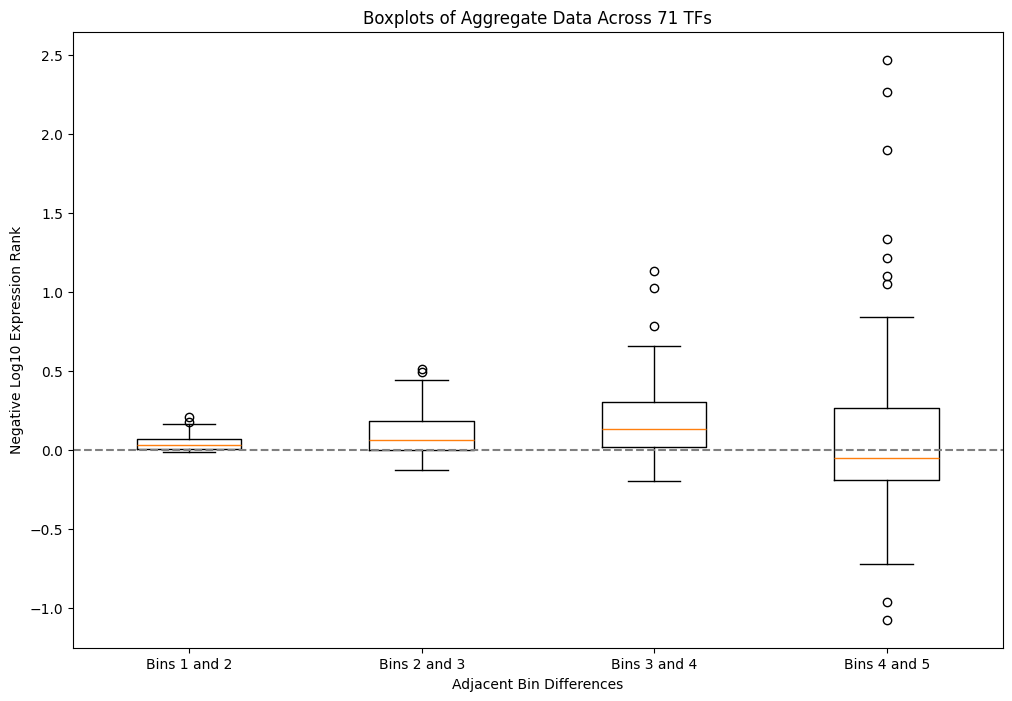

In [372]:
#Run the method on this larger list of TFs
adjacent_differences_box_plot(tfs, boolean_list, "cc", "mcisaac", 5)

These boxplots suggest a much weaker trend is observed when ranking by enrichment values. In fact, given how the rightmost boxplot has a median that is negative, when previous boxplots tend to show the strongest positive increase between Bins 4 and 5, suggests that this trend doesn't hold up well by performing this ranking method. That is, which the left 3 boxplots show a generally positive or netural change in the negative log expression ranks, the rightmost boxplot shows a somewhat mixed spread. It is worth also considering what the boxplot for the first and last bin differences may look like using this ranking method.

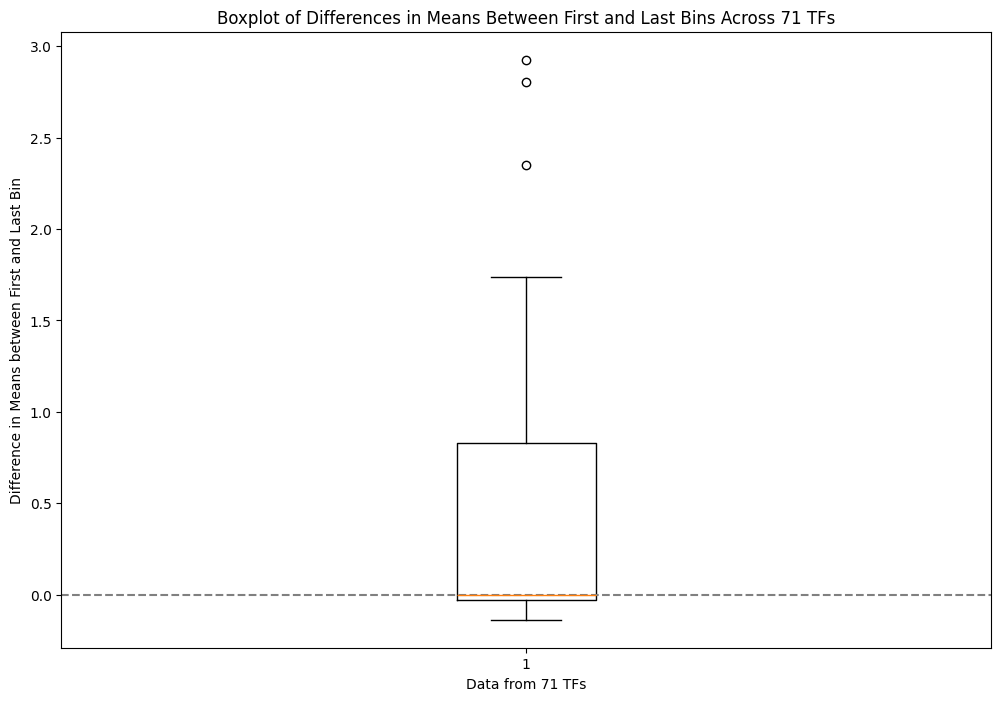

In [374]:
first_last_bin_difference_box_plot(tfs, boolean_list, "cc", "mcisaac", 5)

This boxplot is quite different from the one created originally when ranking by poisson pvalues. Most notably, the lower quartile to the median hovers roughly around zero, while there is a larger spread from the median to the maximum when it comes to the first and last bin mean differences. Ultimately, these two boxplots make it apparent that while ranking by enrichgment may result in higher ranks and less ties, this does not necessarily imply that it produces better trends on the data. However, as a final comparison, we plot these boxplots again, but this time we plot the boxplots from ranking the binding data by pvalues instead to show how the trends differ.

We can use our methods introduced above to compare the boxplots for the mcisaac data ranked using enrichment scores vs. perturbation scores.

In [377]:
tfs = ['WTM1','MIG2','CAT8','PDR1','PHO4','RIM101','GZF3','ASH1','GAT3','TEC1','SIP3','SKN7','WTM2','PHO2','HAA1','ADR1','MET31','CRZ1','RPH1','CHA4','CAD1','ZAP1','SKO1','ACA1','FZF1','HAP2','HAP3','HAP5','INO4','ERT1','TOG1','PPR1','RTG1','GLN3','MOT3','AFT1','CBF1','SUM1','MSN2','DAL80','UPC2','RTG3','GAL80','RSF2','RME1','HIR2','SIP4','HAP4','UME1','MET32','USV1','MGA1','CIN5','ROX1','XBP1','ZNF1','YHP1','RDR1','PDR3','RLM1','SFL1','SMP1','SUT2','HAC1','PHD1','ARO80']
boolean_list = [True]*54 + [False]*12
cc_mcisaac_adjacent_enrichment_data = adjacent_differences_store_data(tfs, boolean_list, "cc", perturbation_sources = ["mcisaac"], bins = 5)

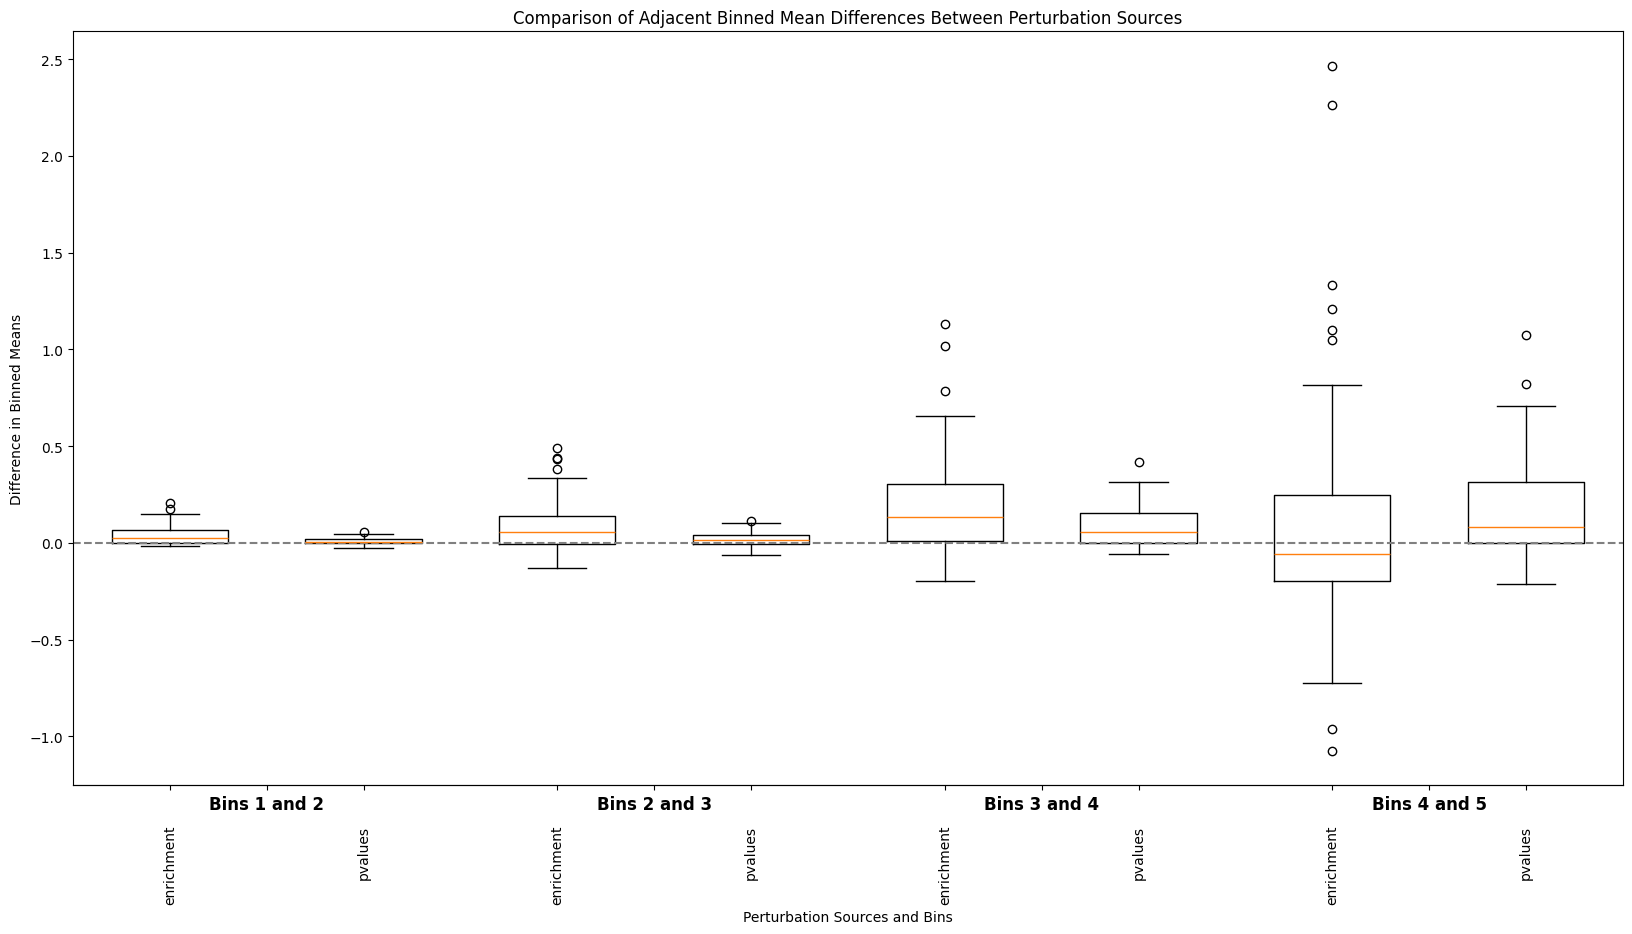

In [378]:
stored_data_list = [cc_mcisaac_adjacent_enrichment_data, cc_mcisaac_adjacent_data]
labels = ['enrichment', 'pvalues']
compare_adjacent_stored_data_box_plots(stored_data_list, labels)

This comparison is interesting for several reasons. First, the boxplots generated by ranking the data using enrichment values are considerably more spread out, suggesting greater variability using this method, While the medians for the first three adjacent bin differences using ranking by enrichment are slightly higher than ranking by poisson pvalues, the comparison of the rightbox boxplots shows that ranking by poisson pvalues is more optimal as the boxplot spread is mainly positive whereas the boxplot generating by ranking using enrichment has an overall neutral spread. Let us also look at how the first and last bin mean difference boxplots compare against one another.

In [379]:
cc_mcisaac_first_last_enrichment_data = first_last_bin_difference_box_plot_comparisons(tfs, boolean_list, "cc", perturbation_sources = ["mcisaac"], bins = 5)

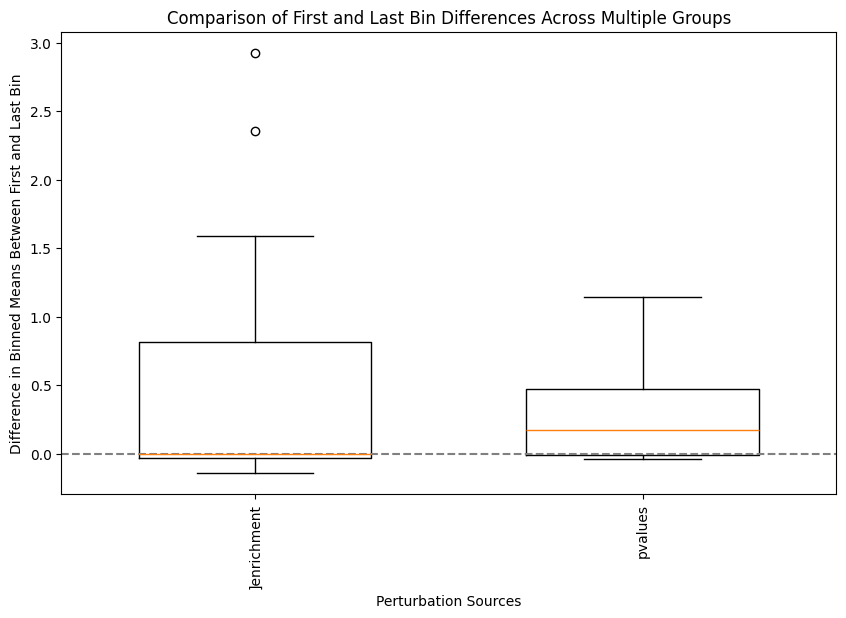

In [380]:
stored_data_list = [cc_mcisaac_first_last_enrichment_data, cc_mcisaac_first_last_data]
labels = [']enrichment', 'pvalues']
compare_first_and_last_stored_data_box_plots(stored_data_list, labels)

By ranking with poisson pvalues, we obtain a boxplot with both a smaller spread and a greater distribution of data that is above 0. Again, since the data in the lower quartile to the median is roughly 0 when ranking by enrichment, this is less optimal when compared to the boxplot ranking by poisson pvalues as more of the data generally exhibits a positive trend. Thus, we conclude continuing to plot by the poisson p values is likely the most optimal way to produce an observable trend for the eventual model to learn from.

### A comprehensive comparison of all boxplots

We have shown above multiple comparisons between various binding and peturbation sources, as well as methods for ranking data. Now, we want to compile a comprehensive comparison of the first and last bin mean difference boxplots across the various binding and perturbation sources. We will use our regular method of ranking the perturbation data, and continue using the poisson pvalues when ranking the binding data. Having these boxplots together will give us the best visual comparison of how the combinations of data hold up against one another.

In [446]:
# tfs in both mcisaac and harbison and mcisaac, kemmeren, and hu_reimann
all_tfs = ['WTM1','MIG2','RIM101','GZF3','ASH1','GAT3','TEC1','SIP3','SKN7','WTM2','HAA1','MET31','CRZ1','CHA4','ZAP1','SKO1','ACA1','FZF1','HAP2','HAP3','HAP5','INO4','ERT1','PPR1','RTG1','MOT3','CBF1','MSN2','DAL80','RTG3','GAL80','RSF2','RME1','HIR2','SIP4','HAP4','UME1','USV1','MGA1','CIN5','ROX1','XBP1','RDR1','PDR3','RLM1','SFL1','SMP1','SUT2','PHD1']
boolean_list = [True]*41 + [False]*8

In [431]:
cc_kemmeren_first_last_data = first_last_bin_difference_box_plot_comparisons(all_tfs, boolean_list, "cc", perturbation_sources = ["kemmeren"], bins = 5)
cc_mcisaac_first_last_data = first_last_bin_difference_box_plot_comparisons(all_tfs, boolean_list, "cc", perturbation_sources = ["mcisaac"], bins = 5)
cc_hu_reimann_first_last_data = first_last_bin_difference_box_plot_comparisons(all_tfs, boolean_list, "cc", perturbation_sources = ["hu_reimann"], bins = 5)

In [432]:
harbison_kemmeren_first_last_data = first_last_bin_difference_box_plot_comparisons(all_tfs, boolean_list, "harbison", perturbation_sources = ["kemmeren"], bins = 5)
harbison_mcisaac_first_last_data = first_last_bin_difference_box_plot_comparisons(all_tfs, boolean_list, "harbison", perturbation_sources = ["mcisaac"], bins = 5)
harbison_hu_reimann_first_last_data = first_last_bin_difference_box_plot_comparisons(all_tfs, boolean_list, "harbison", perturbation_sources = ["hu_reimann"], bins = 5)

Here, we create a new method to plot the data in this array format. The y-axes are all standardized to show each boxplot and provide ease of comparison when looking at two differen boxplots across different rows or columns.

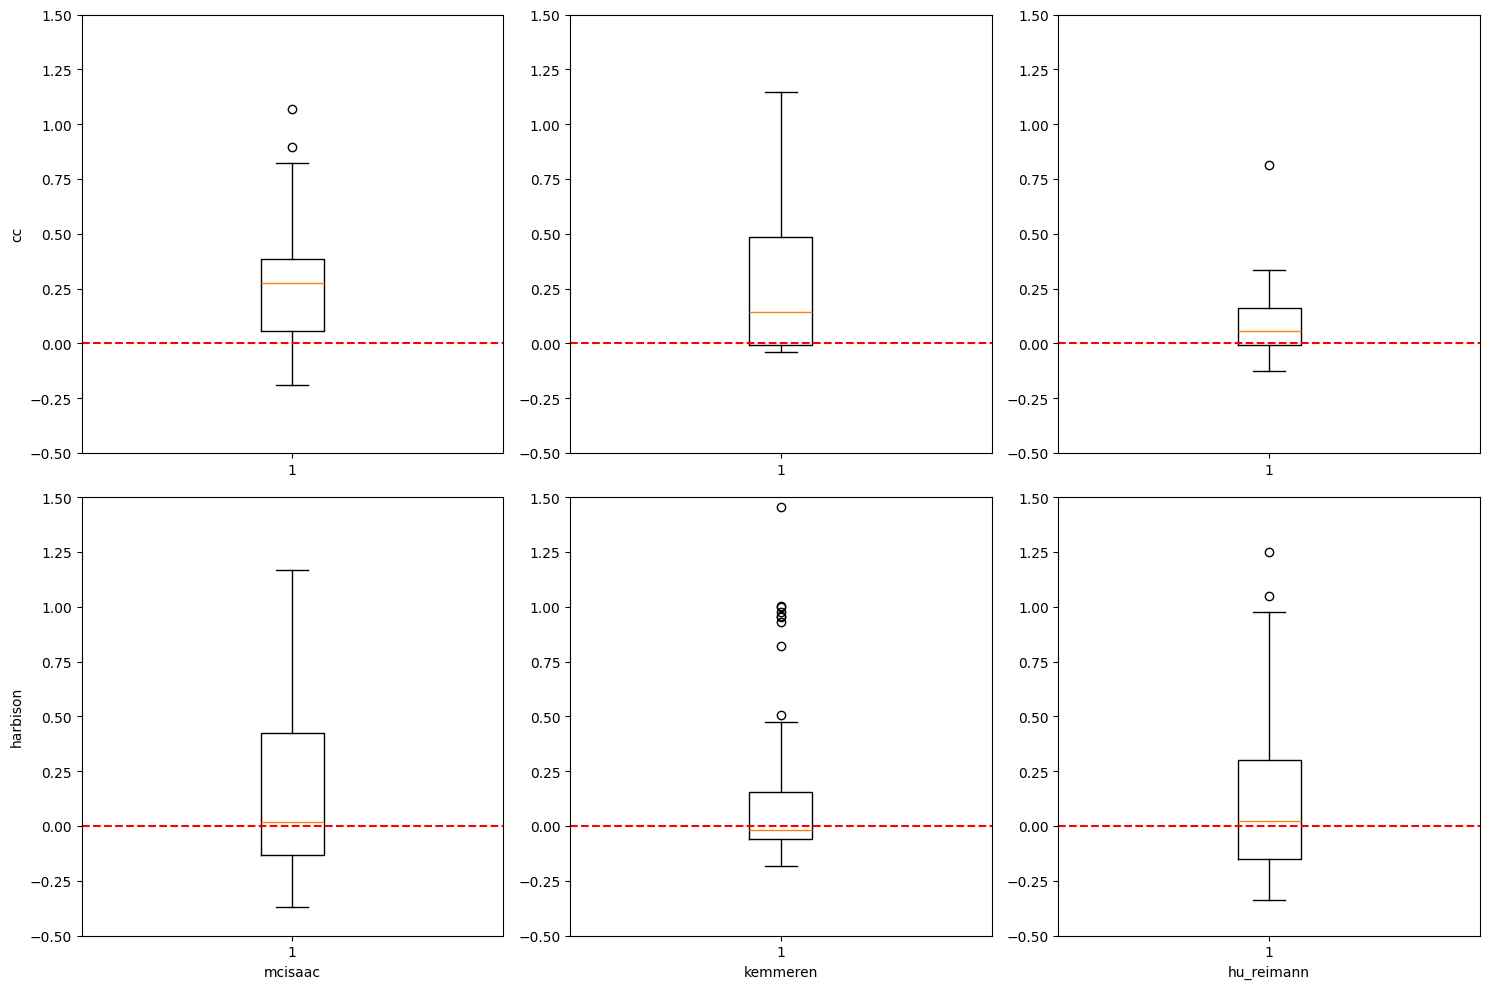

In [447]:
def plot_boxplots(data: List[List[float]], binding_labels: List[str], perturbation_labels: List[str]) -> None:
    """
    Plots a 2x3 array of boxplots with specified binding and perturbation labels.
    
    Parameters:
    data (List[List[float]]): A list of lists containing numerical data for each boxplot.
    binding_labels (List[str]): A list containing the labels for the binding data ("cc" and "harbison").
    perturbation_labels (List[str]): A list containing the labels for the perturbation data ("mcisaac", "kemmeren", "hu_reimann").
    
    Returns:
    None
    """
    fig, axs = plt.subplots(2, 3, figsize=(15, 10))
    axs = axs.flatten()  # Flatten the 2x3 array to iterate over it easily
    
    for i, ax in enumerate(axs):
        if i < len(data):
            ax.boxplot(data[i])
            row = i // 3
            col = i % 3
            #ax.set_title(f"{binding_labels[row]} - {perturbation_labels[col]}")
            if col == 0:
                ax.set_ylabel(binding_labels[row])
            if row == 1:
                ax.set_xlabel(perturbation_labels[col])
            ax.axhline(y=0, color='r', linestyle='--')  # Add dashed line at y=0
            ax.set_ylim(-0.5, 1.5)  # Set y-axis limits
        else:
            ax.axis('off')  # Turn off any unused subplot axes
    
    plt.tight_layout()
    plt.show()

data = [cc_kemmeren_first_last_data['kemmeren'], cc_mcisaac_first_last_data['mcisaac'], cc_hu_reimann_first_last_data['hu_reimann'], harbison_kemmeren_first_last_data['kemmeren'], harbison_mcisaac_first_last_data['mcisaac'], harbison_hu_reimann_first_last_data['hu_reimann']]
binding_labels = ["cc", "harbison"]
perturbation_labels = ["mcisaac", "kemmeren", "hu_reimann"]
plot_boxplots(data, binding_labels, perturbation_labels)

From the 49 TFs that these binding and perturbation datasets have in common, this comparison of all of the boxplots gives us a good idea of how these datasets measure up to one another. The x-axis labels the perturbation dataset used, while the y-axis labels the binding dataset used. Immediately, when focusing on the bottom row in contrast to the top row, which is comparing the two binding sources, it is evident that using the harbison binding data produces more points within the boxplot that are near zero. In each of the 3 boxplots on the bottom row, the median is at or very close to 0 and the lower quartile is negative. Clearly, it appears that the harbison data doesn't yield as desirable of a trend as the Calling Cards data does. 

On the other hand, looking at the top row of data using the Calling Cards binding data, the boxplots clearly depict a more desirable and overall positive trend across all 3 perturbation datasets. Once again, the main comparison seems to be between using mcisaac and kemmeren as the perturbation data source. Earlier, we analyzed these two boxplots, and we acknowledged the strengths of both. Using mcisaac, the median is substanially higher than using kemmeren, whereas kemmeren's upper quartile contains points that are substantially larger compared to mcisaac. It seems that overall, using the Calling Cards binding data and either mcisaac or kemmeren perturbation datasets will yield the most desirable trends across various TFs.